# Notebook containing code used for manuscript figure 5

### Change each file path to the relevant local folder after downloading the data

In [1]:
import anndata
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default='iframe'
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn import linear_model

import cv2
from skimage.segmentation import find_boundaries

import commot as ct
import spateo as st
import dynamo as dyn

import torch
from torch import nn

import pickle
import os
import sys
from tqdm import tqdm

from scipy.spatial import KDTree

2024-08-17 03:32:22.033841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-17 03:32:23.008196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 03:32:24.467872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%config InlineBackend.print_figure_kwargs={'dpi': 300.0}

In [3]:
np.random.seed(0)

# Digitization

## Resources used for the digitization benchmarks (simulations and macaque cortex) can all be found here (along with files for the Supplementary Figure 5 digitization materials): https://www.dropbox.com/scl/fo/4tyq5nbex7e2yo3anuemy/AA2p0y9ZAnN6oLWgAtoWA-0?rlkey=jdnxyg8jwx17iexxyn8dvqi7y&st=rsf779qu&dl=0

## The fitEC R package (not needed here) and slideseq_helpers file can also be found in folders within this Dropbox folder 

In [4]:
# Add slideseq_helpers folder to path
sys.path.insert(0, '/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_digitization_materials/raphael-group-belayer-bb7b493/src')

### Figure 5e- simulated case 1

In [5]:
one_slice_adata = st.read_h5ad("/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_digitization_materials/half_circle_only_coor.h5ad")
one_slice_adata.obs['label'] = "Simulated"
one_slice_adata

AnnData object with n_obs × n_vars = 18526 × 1
    obs: 'x', 'y', 'label'
    uns: '__type'
    obsm: 'spatial'

#### Perform Spateo digitization

In [6]:
cluster_label_image_lowres = st.dd.gen_cluster_image(one_slice_adata, bin_size=1, spatial_key="spatial", cluster_key='label', show=False)
cluster_label_list = np.unique(one_slice_adata.obs["cluster_img_label"])
contours, cluster_image_close, cluster_image_contour = st.dd.extract_cluster_contours(cluster_label_image_lowres, cluster_label_list, bin_size=1, k_size=1, show=False)

|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
|-----> Get selected areas with label id(s): [1].
|-----> Close morphology of the area formed by cluster [1].
|-----> Remove small region(s).
|-----> Extract contours.


In [7]:
px.imshow(cluster_image_contour)

In [8]:
# User input to specify a gridding direction
pnt_xY = (116,273)
pnt_xy = (47,273)
pnt_Xy = (308,273)
pnt_XY = (243,273)

# Digitize the area of interest
st.dd.digitize(
    adata=one_slice_adata,
    ctrs=contours,
    ctr_idx=0,
    pnt_xy=pnt_xy,
    pnt_xY=pnt_xY,
    pnt_Xy=pnt_Xy,
    pnt_XY=pnt_XY,
    spatial_key="spatial"
)

|-----> Initialize the field of the spatial domain of interests.
|-----> Prepare the isoline segments with either the highest/lower column or layer heat values.
|-----> Solve the layer heat equation on spatial domain with the iso-layer-line conditions.
|-----> Total iteration: 5938
|-----> Saving layer heat values to digital_layer.
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
18521    0.0
18522    0.0
18523    0.0
18524    0.0
18525    0.0
Name: digital_layer, Length: 18526, dtype: float64
|-----> Solve the column heat equation on spatial domain with the iso-column-line conditions.
|-----> Total iteration: 5924
|-----> Saving column heat values to digital_column.


#### Run Belayer (for comparison in benchmarking)

In [9]:
# Install the following packages (glmpca, alphashape) if not already installed- needed for slideseq_helpers
#!pip install glmpca
#!pip install alphashape

In [10]:
import networkx as nx
from slideseq_helpers import alpha_shape, harmonic_slideseq

In [11]:
coords = one_slice_adata.obsm['spatial'] * 10
edges = list(alpha_shape(coords, alpha=10, only_outer=True))
G = nx.DiGraph(edges)

edge_pt=list(nx.simple_cycles(G))
edge_pts=[(coords[e,0],coords[e,1]) for e in edge_pt[0]]
len(edge_pts)

646

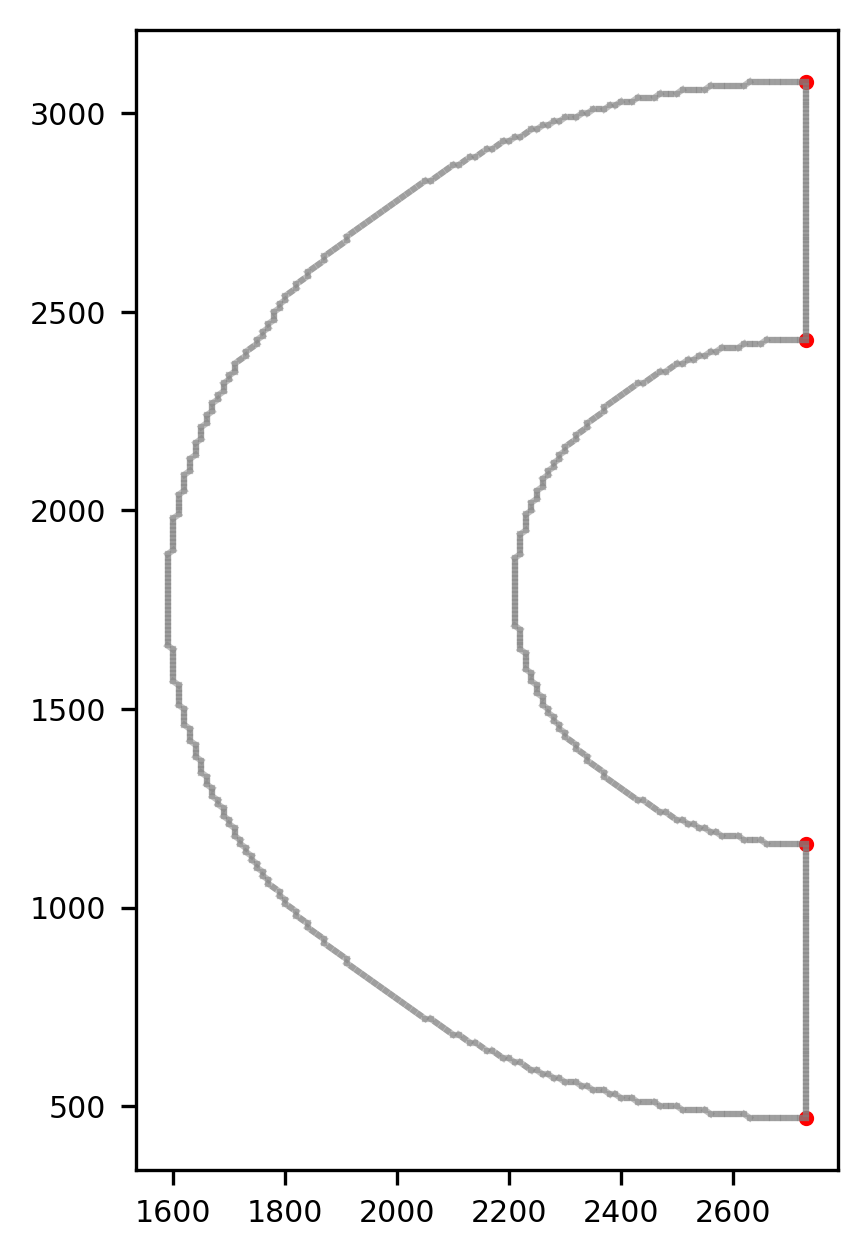

In [12]:
len(edge_pts)
##%%
fig, ax = plt.subplots(figsize=(3,5))
for i, j in edges:
    plt.plot(coords[[i, j], 0], coords[[i, j], 1], color='grey', ls='-',alpha=0.5)

plt.scatter(coords[:,0],coords[:,1],s=2,color='white')


x, y = edge_pts[162]
plt.scatter(x, y, s=10, color='red')

x, y = edge_pts[231]
plt.scatter(x, y, s=10, color='red')

x, y = edge_pts[396]
plt.scatter(x, y, s=10, color='red')

x, y = edge_pts[461]
plt.scatter(x, y, s=10, color='red')

starting harmonic interpolation...


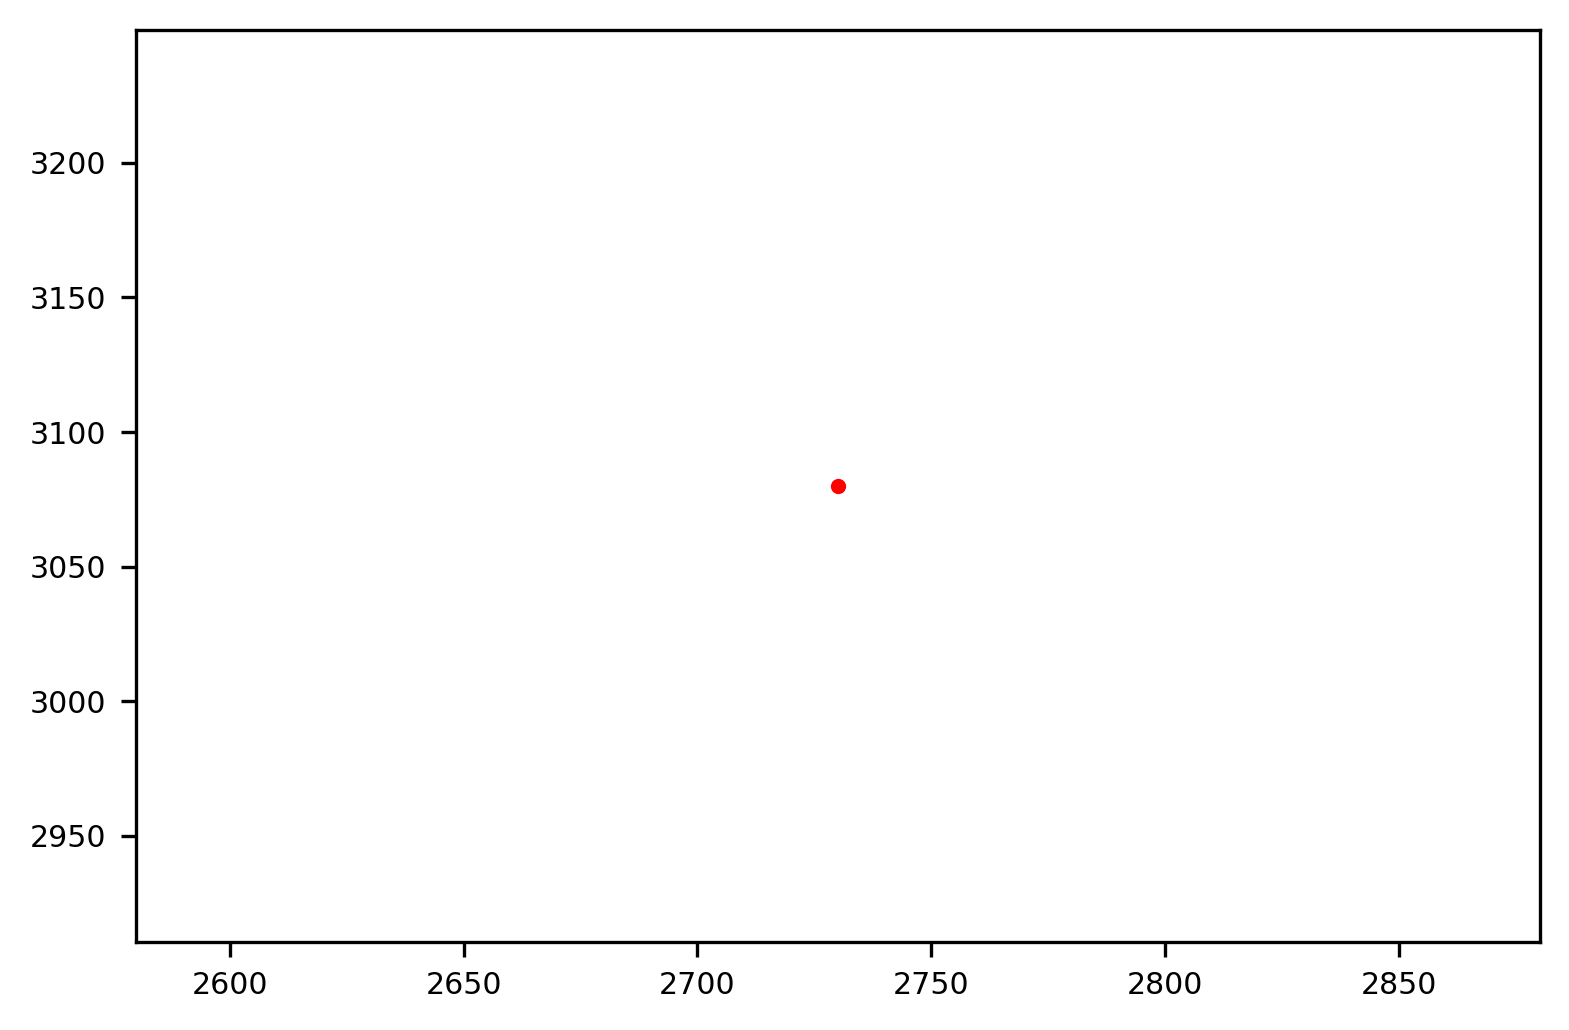

In [13]:
plt.scatter(x, y, s=10, color='red')
##%%
boundary_array = []

bound_2 = edge_pts[461:646]
bound_2 = bound_2+edge_pts[0:162+1]
boundary_array.append(np.array([[i[0], i[1]] for i in bound_2]))

boundary_array.append(np.array([[i[0], i[1]] for i in edge_pts[231:396+1]]))

one_slice_adata.obs['belayer'] = harmonic_slideseq(coords, boundary_array, grid_spacing=25, radius=1)

In [14]:
boundary_array = []

boundary_array.append(np.array([[i[0], i[1]] for i in edge_pts[162:231+1]]))

bound_2 = edge_pts[396:461+1]
boundary_array.append(np.array([[i[0], i[1]] for i in bound_2]))

one_slice_adata.obs['belayer_column'] = harmonic_slideseq(coords, boundary_array, grid_spacing=25, radius=10)

starting harmonic interpolation...


In [15]:
one_slice_adata.obs['digital_layer'] = one_slice_adata.obs['digital_layer']/one_slice_adata.obs['digital_layer'].max() * 100 // 1
one_slice_adata.obs['belayer'] = one_slice_adata.obs['belayer']/one_slice_adata.obs['belayer'].max() * 100 // 1

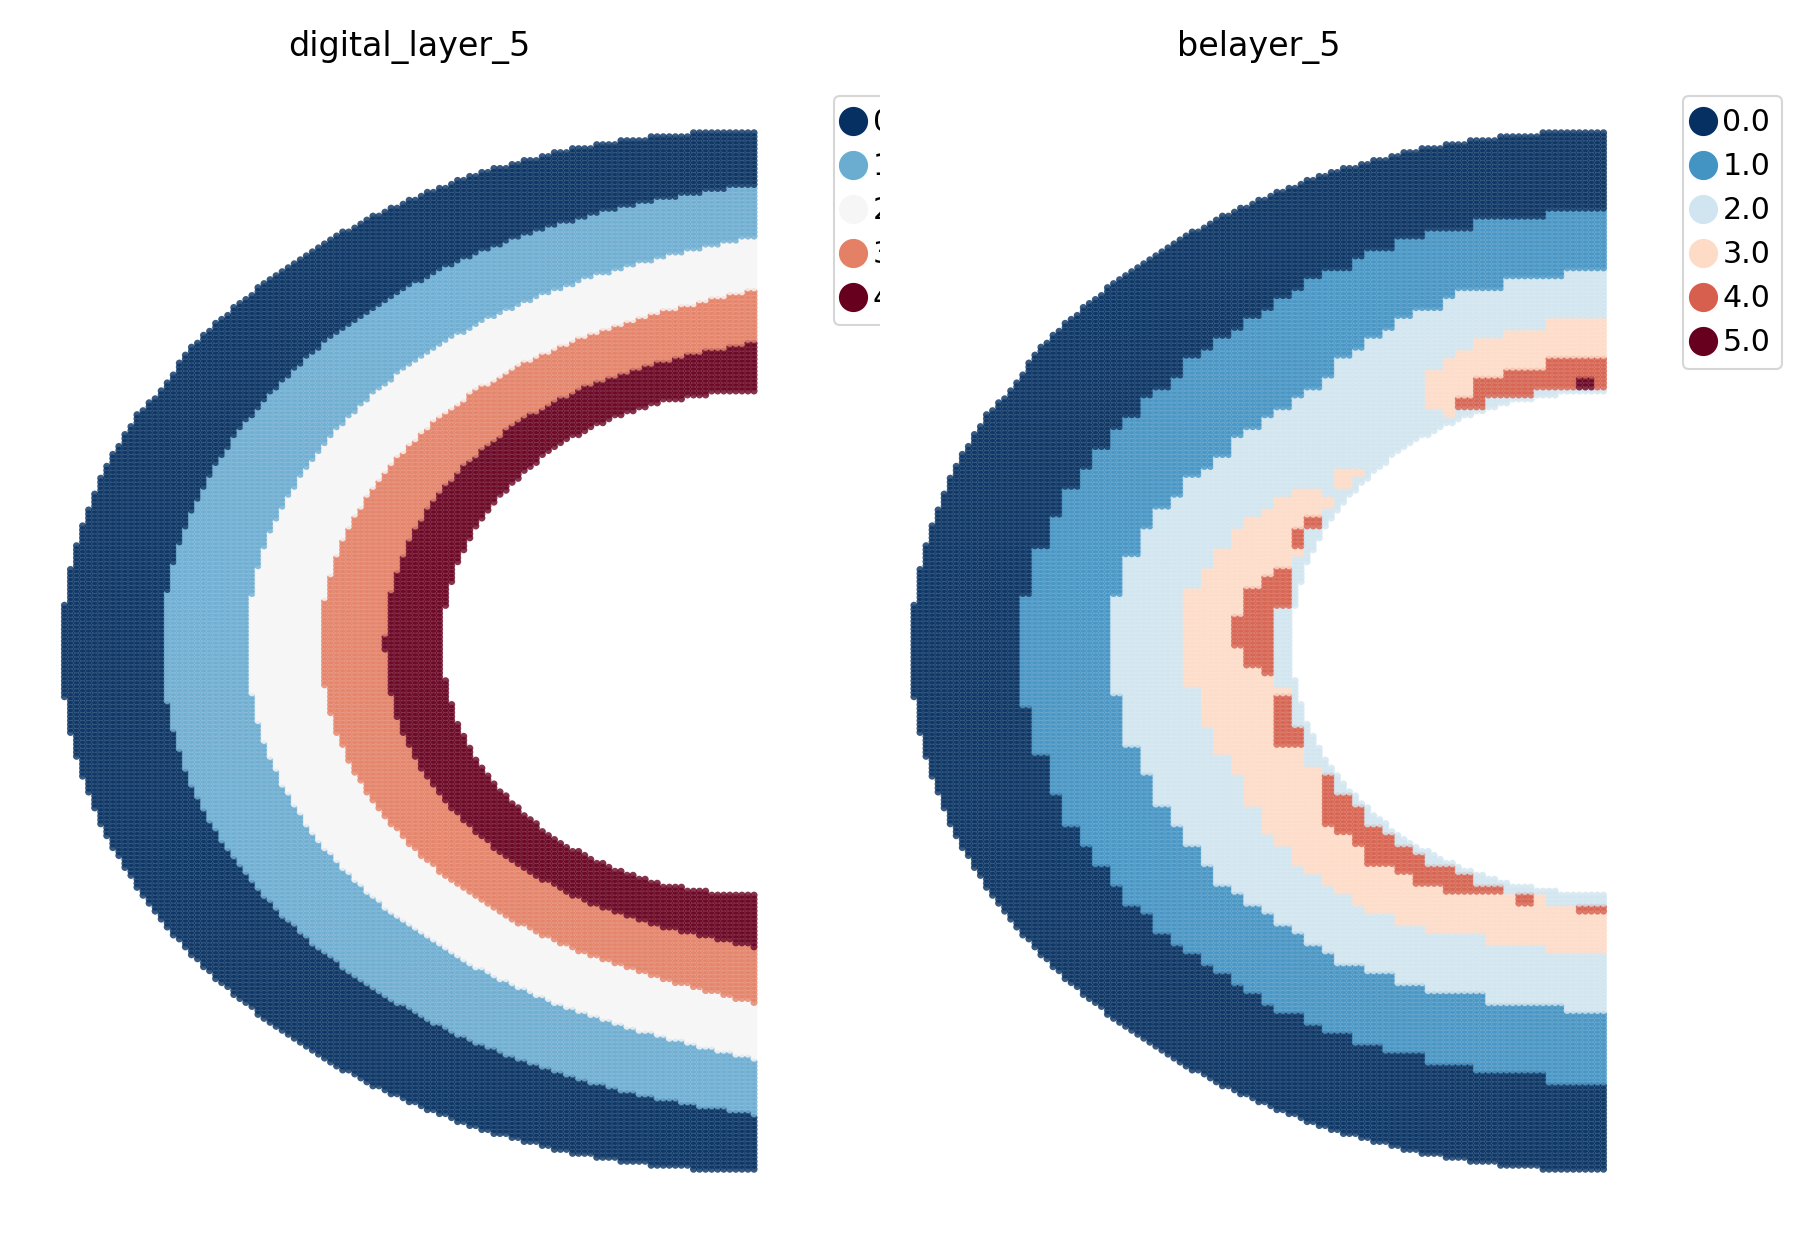

In [16]:
one_slice_adata.obs['digital_layer_5'] = (one_slice_adata.obs['digital_layer']-1)//20
one_slice_adata.obs['belayer_5'] = (one_slice_adata.obs['belayer'])//20 
one_slice_adata.obs['digital_layer_5'] = one_slice_adata.obs['digital_layer_5'].astype(str)
one_slice_adata.obs['belayer_5'] = one_slice_adata.obs['belayer_5'].astype(str)
st.pl.space(
    one_slice_adata,
    color=['digital_layer_5', 'belayer_5'],
    ncols=2,
    pointsize=0.1,
    show_legend="upper left",
    figsize=(4, 5),
    color_key_cmap = "RdBu_r",
)

In [17]:
one_slice_adata.obs['digital_column'] = one_slice_adata.obs['digital_column']/one_slice_adata.obs['digital_column'].max() * 100 // 1
one_slice_adata.obs['belayer_column'] = one_slice_adata.obs['belayer_column']/one_slice_adata.obs['belayer_column'].max() * 100 // 1

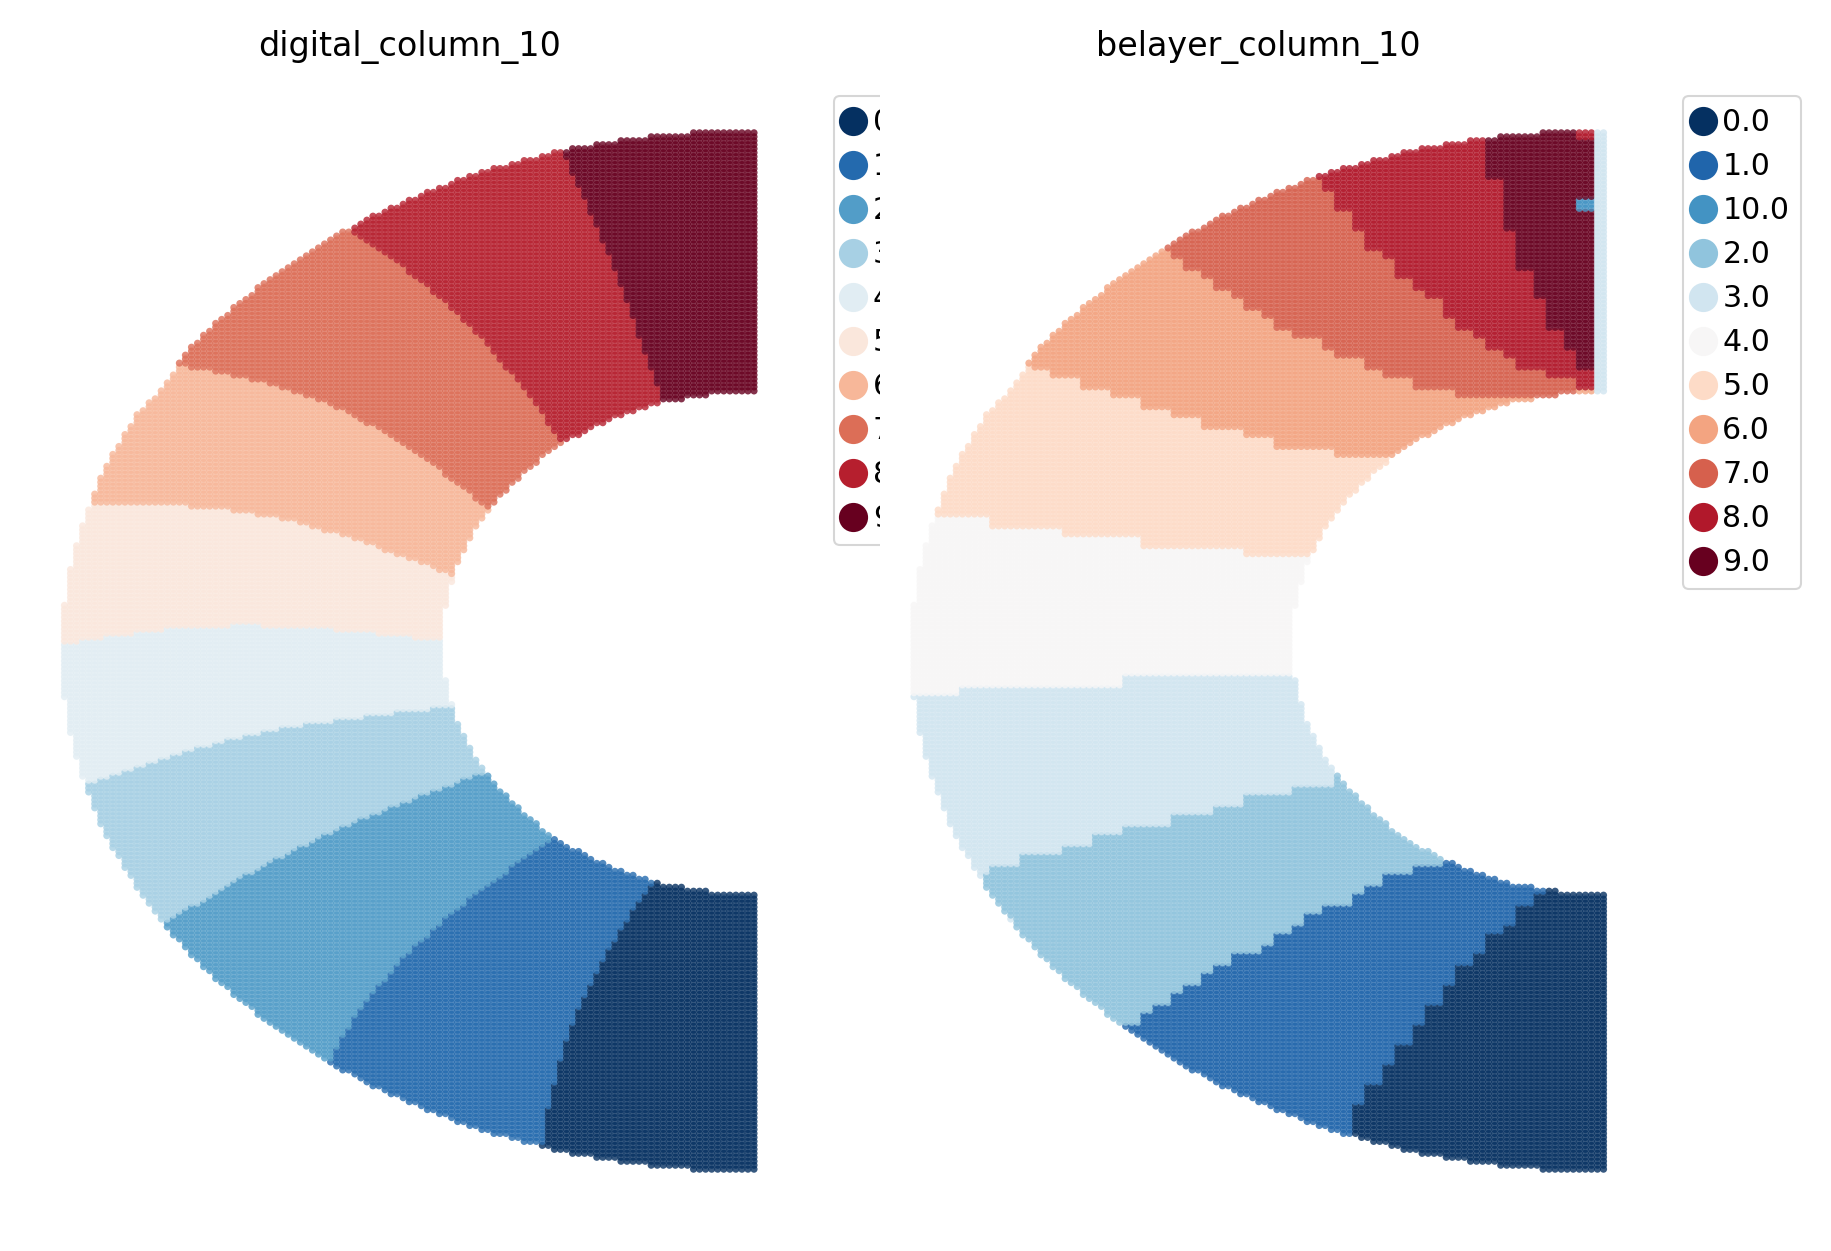

In [18]:
one_slice_adata.obs['digital_column_10'] = (one_slice_adata.obs['digital_column']-1)//10
one_slice_adata.obs['belayer_column_10'] = (one_slice_adata.obs['belayer_column'])//10 
one_slice_adata.obs['digital_column_10'] = one_slice_adata.obs['digital_column_10'].astype(str)
one_slice_adata.obs['belayer_column_10'] = one_slice_adata.obs['belayer_column_10'].astype(str)
st.pl.space(
    one_slice_adata,
    color=['digital_column_10', 'belayer_column_10'],
    ncols=2,
    pointsize=0.1,
    show_legend="upper left",
    figsize=(4, 5),
    color_key_cmap = "RdBu_r",
)

### Figure 5f- simulated case 2

In [19]:
one_slice_adata = st.read_h5ad("/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_digitization_materials/fanshape_only_coor.h5ad")
one_slice_adata.obs['label'] = "Simulated"
one_slice_adata

AnnData object with n_obs × n_vars = 2186 × 1
    obs: 'x', 'y', 'label'
    uns: '__type'
    obsm: 'spatial'

#### Perform Spateo digitization

In [20]:
cluster_label_image_lowres = st.dd.gen_cluster_image(one_slice_adata, bin_size=1, spatial_key="spatial", cluster_key='label', show=False)
cluster_label_list = np.unique(one_slice_adata.obs["cluster_img_label"])
contours, cluster_image_close, cluster_image_contour = st.dd.extract_cluster_contours(cluster_label_image_lowres, cluster_label_list, bin_size=1, k_size=1, show=False)

|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
|-----> Get selected areas with label id(s): [1].
|-----> Close morphology of the area formed by cluster [1].
|-----> Remove small region(s).
|-----> Extract contours.


In [21]:
px.imshow(cluster_image_contour)

In [22]:
# User input to specify a gridding direction
pnt_xY = (172,213)
pnt_xy = (141,164)
pnt_Xy = (214,164)
pnt_XY = (184,213)

# Digitize the area of interest
st.dd.digitize(
    adata=one_slice_adata,
    ctrs=contours,
    ctr_idx=0,
    pnt_xy=pnt_xy,
    pnt_xY=pnt_xY,
    pnt_Xy=pnt_Xy,
    pnt_XY=pnt_XY,
    spatial_key="spatial"
)

|-----> Initialize the field of the spatial domain of interests.
|-----> Prepare the isoline segments with either the highest/lower column or layer heat values.
|-----> Solve the layer heat equation on spatial domain with the iso-layer-line conditions.
|-----> Total iteration: 1944
|-----> Saving layer heat values to digital_layer.
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2181    0.0
2182    0.0
2183    0.0
2184    0.0
2185    0.0
Name: digital_layer, Length: 2186, dtype: float64
|-----> Solve the column heat equation on spatial domain with the iso-column-line conditions.
|-----> Total iteration: 1937
|-----> Saving column heat values to digital_column.


#### Run Belayer (for comparison in benchmarking)

In [23]:
import networkx as nx
from slideseq_helpers import alpha_shape, harmonic_slideseq

In [24]:
coords = one_slice_adata.obsm['spatial'] * 10
edges = list(alpha_shape(coords, alpha=10, only_outer=True))
G = nx.DiGraph(edges)

edge_pt=list(nx.simple_cycles(G))
edge_pts=[(coords[e,0],coords[e,1]) for e in edge_pt[0]]
len(edge_pts)

183

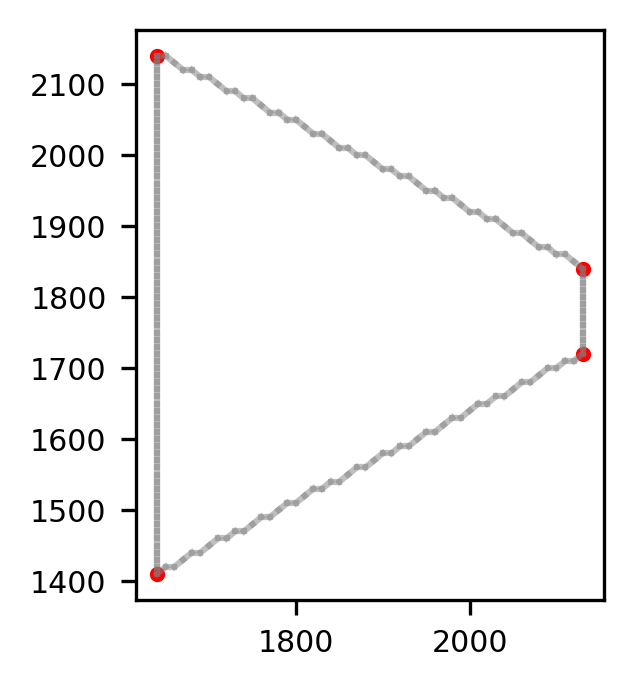

In [25]:
fig, ax = plt.subplots(figsize=(2,2.5))
for i, j in edges:
    plt.plot(coords[[i, j], 0], coords[[i, j], 1], color='grey', ls='-',alpha=0.5)

plt.scatter(coords[:,0],coords[:,1],s=2,color='white')


x, y = edge_pts[49]
plt.scatter(x, y, s=10, color='red')

x, y = edge_pts[61]
plt.scatter(x, y, s=10, color='red')

x, y = edge_pts[110]
plt.scatter(x, y, s=10, color='red')

x, y = edge_pts[0]
plt.scatter(x, y, s=10, color='red')

In [26]:
boundary_array = []

bound_2 = edge_pts[110:183]
bound_2 = bound_2+edge_pts[0:0+1]
boundary_array.append(np.array([[i[0], i[1]] for i in bound_2]))

boundary_array.append(np.array([[i[0], i[1]] for i in edge_pts[49:61+1]]))

one_slice_adata.obs['belayer'] = harmonic_slideseq(coords, boundary_array, grid_spacing=25, radius=1)

starting harmonic interpolation...


In [27]:
boundary_array = []

boundary_array.append(np.array([[i[0], i[1]] for i in edge_pts[0:49+1]]))

bound_2 = edge_pts[61:110+1]
boundary_array.append(np.array([[i[0], i[1]] for i in bound_2]))

one_slice_adata.obs['belayer_column'] = harmonic_slideseq(coords, boundary_array, grid_spacing=25, radius=1)

starting harmonic interpolation...


In [28]:
one_slice_adata.obs['digital_layer'] = one_slice_adata.obs['digital_layer']/one_slice_adata.obs['digital_layer'].max() * 100 // 1
one_slice_adata.obs['belayer'] = one_slice_adata.obs['belayer']/one_slice_adata.obs['belayer'].max() * 100 // 1

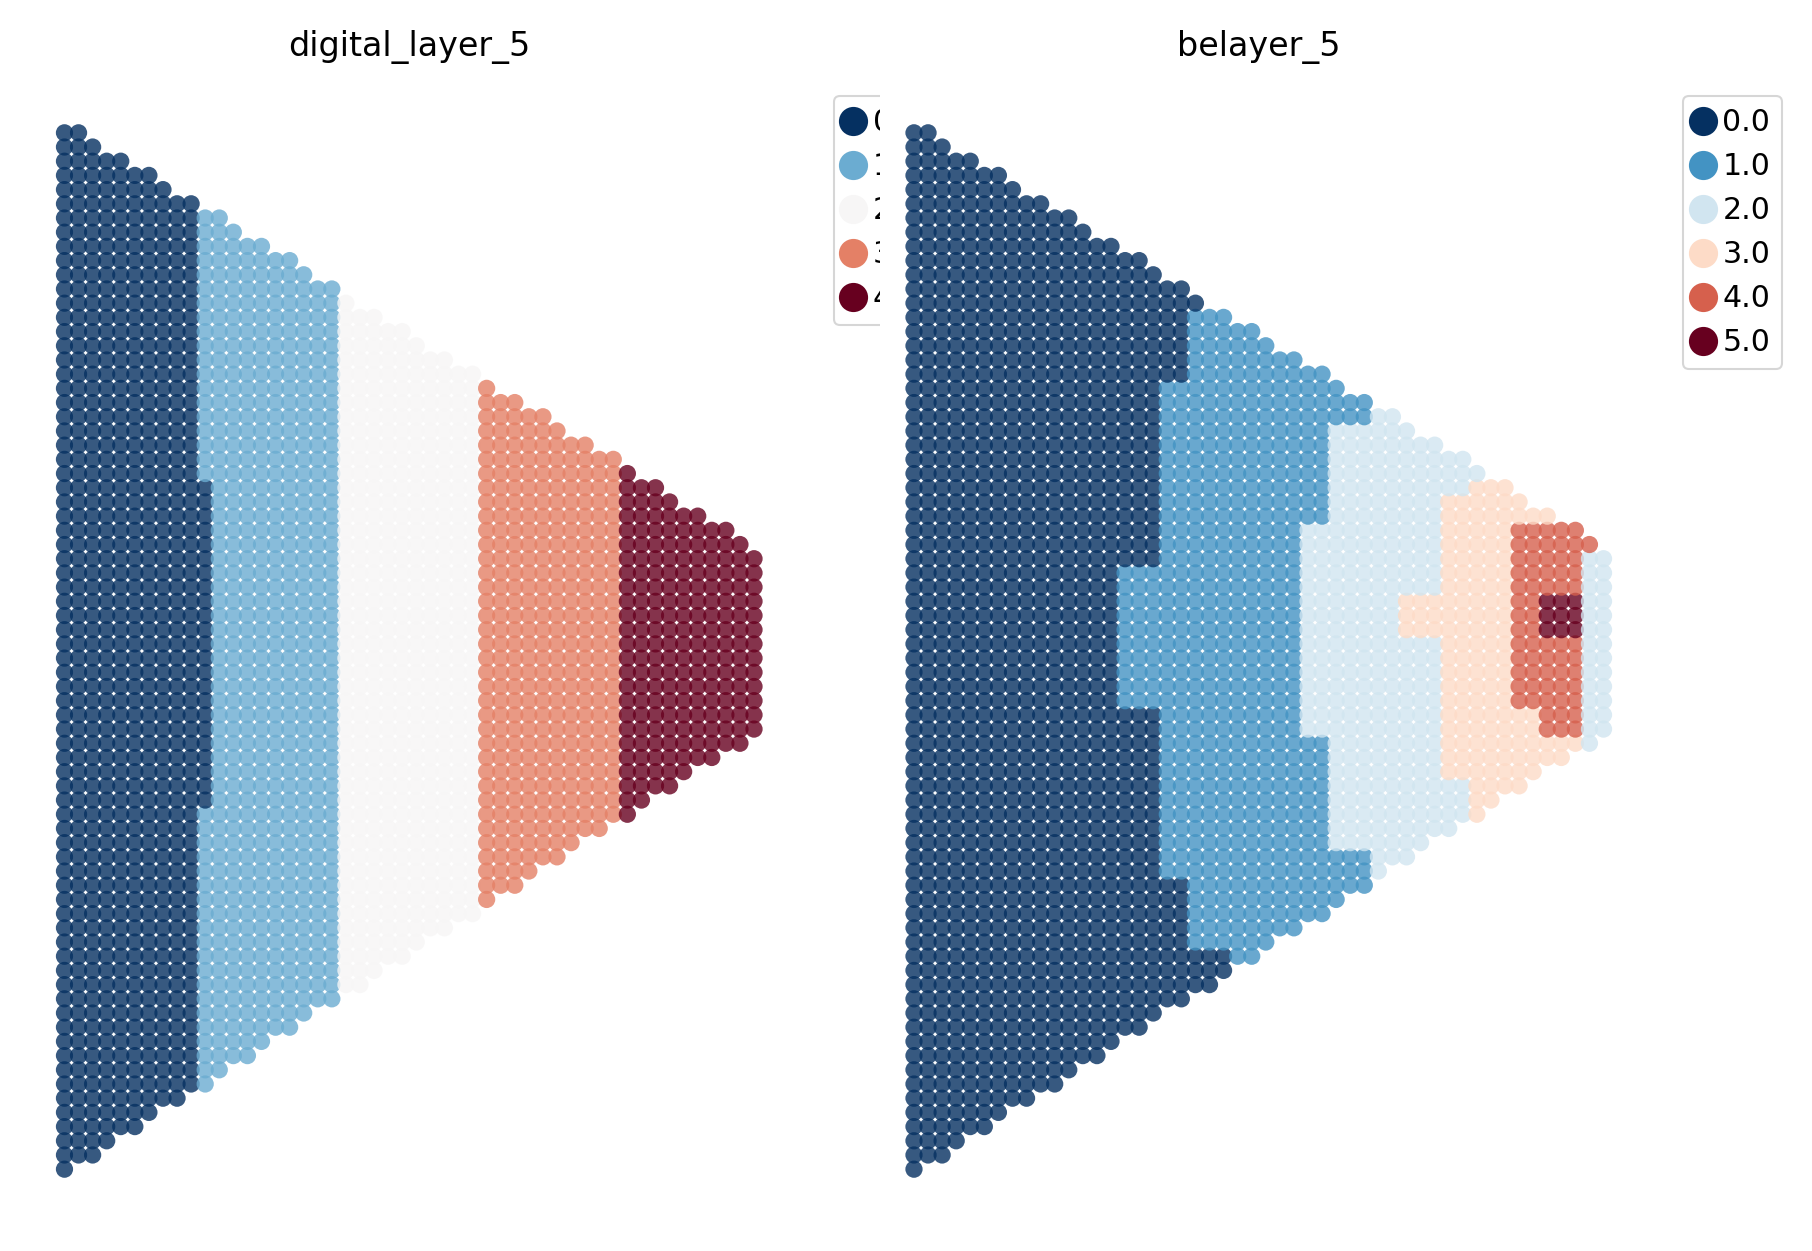

In [29]:
one_slice_adata.obs['digital_layer_5'] = (one_slice_adata.obs['digital_layer']-1)//20
one_slice_adata.obs['belayer_5'] = (one_slice_adata.obs['belayer'])//20 
one_slice_adata.obs['digital_layer_5'] = one_slice_adata.obs['digital_layer_5'].astype(str)
one_slice_adata.obs['belayer_5'] = one_slice_adata.obs['belayer_5'].astype(str)
st.pl.space(
    one_slice_adata,
    color=['digital_layer_5', 'belayer_5'],
    ncols=2,
    pointsize=0.2,
    show_legend="upper left",
    figsize=(4, 5),
    color_key_cmap = "RdBu_r",
)

In [30]:
one_slice_adata.obs['digital_column'] = one_slice_adata.obs['digital_column']/one_slice_adata.obs['digital_column'].max() * 100 // 1
one_slice_adata.obs['belayer_column'] = one_slice_adata.obs['belayer_column']/one_slice_adata.obs['belayer_column'].max() * 100 // 1

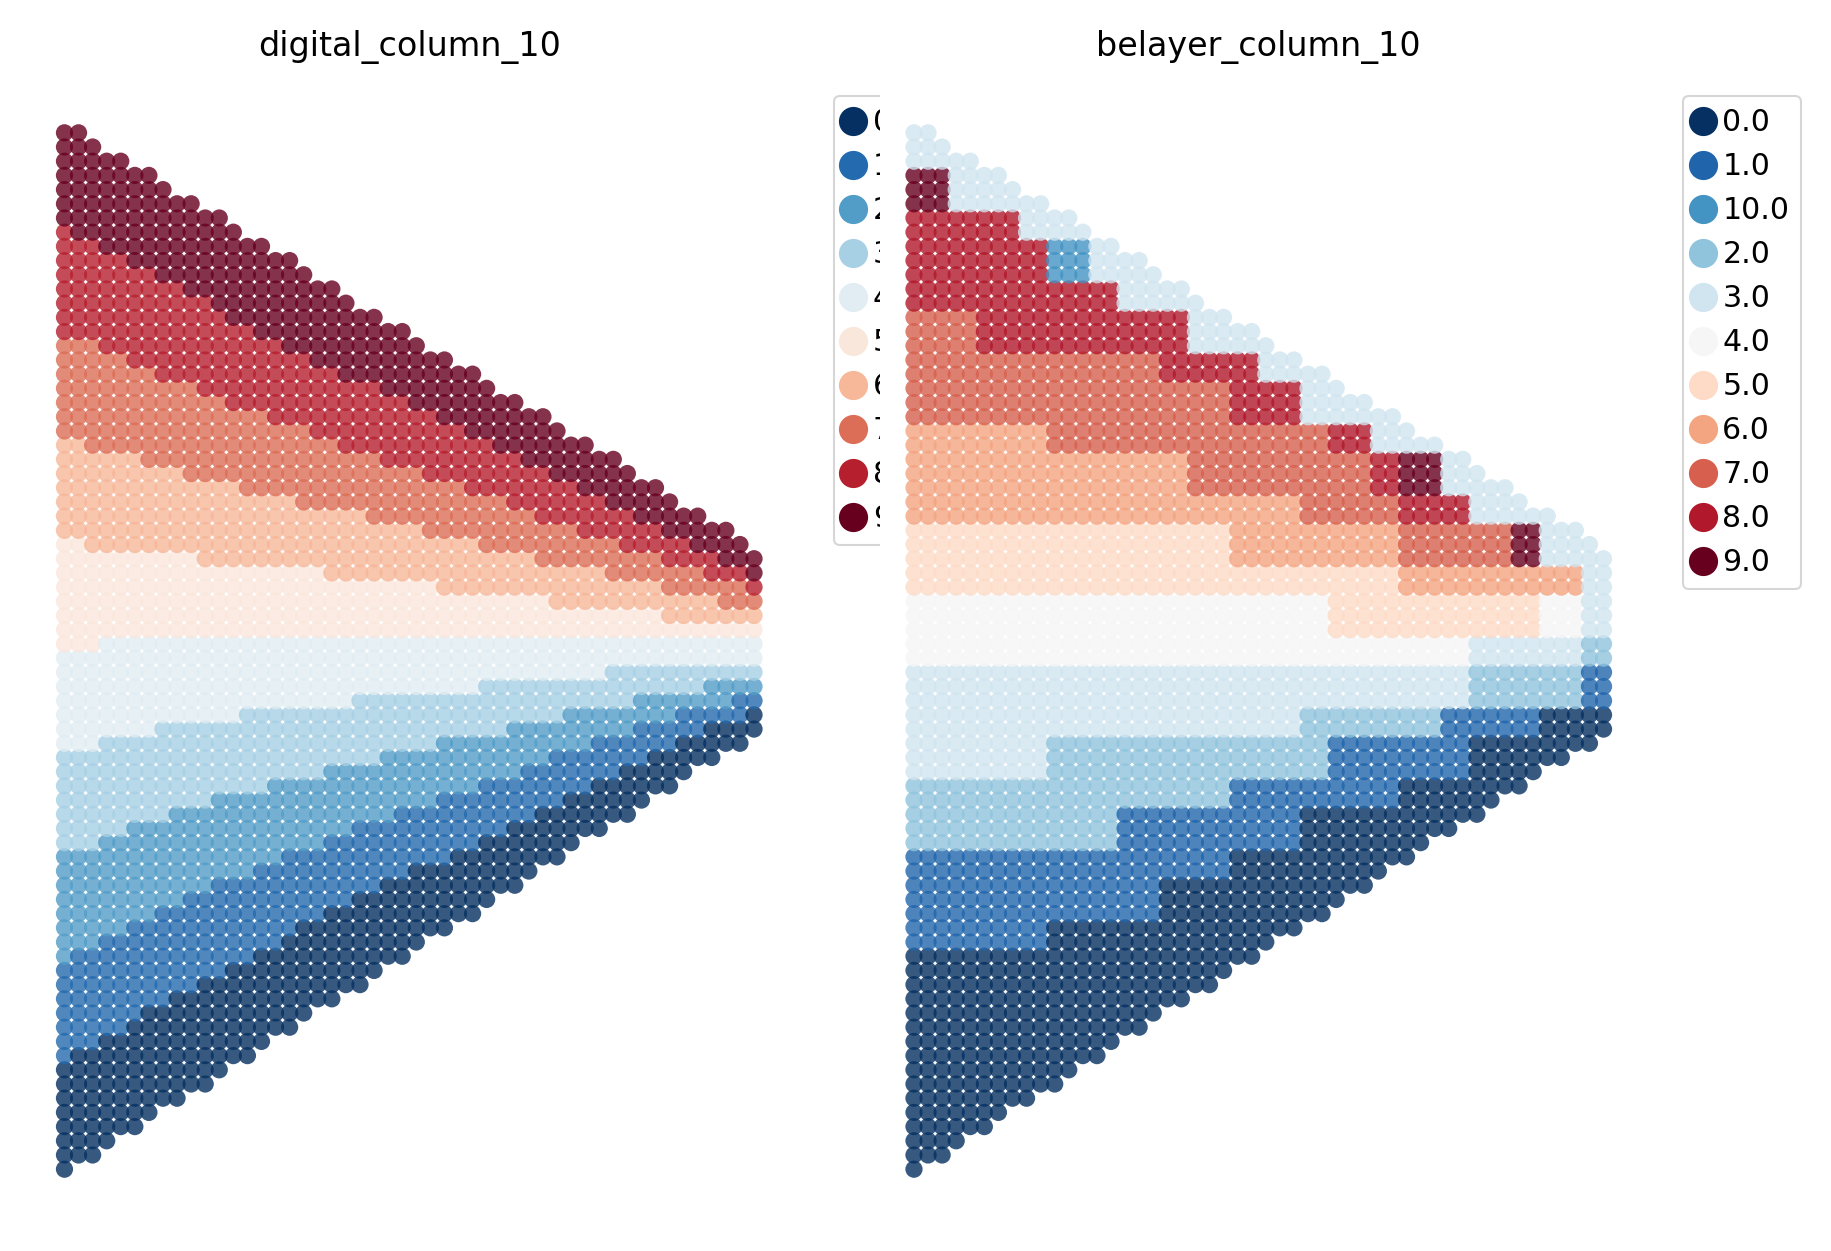

In [31]:
one_slice_adata.obs['digital_column_10'] = (one_slice_adata.obs['digital_column']-1)//10
one_slice_adata.obs['belayer_column_10'] = (one_slice_adata.obs['belayer_column'])//10 
one_slice_adata.obs['digital_column_10'] = one_slice_adata.obs['digital_column_10'].astype(str)
one_slice_adata.obs['belayer_column_10'] = one_slice_adata.obs['belayer_column_10'].astype(str)
st.pl.space(
    one_slice_adata,
    color=['digital_column_10', 'belayer_column_10'],
    ncols=2,
    pointsize=0.2,
    show_legend="upper left",
    figsize=(4, 5),
    color_key_cmap = "RdBu_r",
)

### Figure 5g- macaque cortex

In [32]:
one_slice_adata = st.read_h5ad("/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_digitization_materials/T40_adata_only_coor.h5ad")
one_slice_adata.obs['label'] = "T40"
one_slice_adata

AnnData object with n_obs × n_vars = 323749 × 1
    obs: 'cell_id', 'brain_section_label', 'monkey', 'batch', 'x', 'y', 'cell_type', 'cell_type_colors', 'label'
    uns: '__type'
    obsm: 'spatial'

#### Perform Spateo digitization

In [33]:
one_slice_adata.obsm['spatial_bin50'] = one_slice_adata.obsm['spatial']//50
subset = one_slice_adata[one_slice_adata.obs['cell_type'].isin(['L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6']), :].copy()

In [34]:
cluster_label_image_lowres = st.dd.gen_cluster_image(subset, bin_size=1, spatial_key="spatial_bin50", cluster_key='cell_type', show=False)
cluster_label_list = np.unique(subset.obs["cluster_img_label"])

|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.


In [35]:
from skimage import morphology

close_kernel=cv2.MORPH_ELLIPSE
bin_size=1
k_size = 9
min_area = 9000
cluster_label_image = cluster_label_image_lowres
cluster_labels = cluster_label_list

cluster_image_close = cluster_label_image.copy()
if type(cluster_labels) == int:
    cluster_image_close = np.where(cluster_image_close == cluster_labels, cluster_image_close, 0)
else:
    cluster_image_close = np.where(np.isin(cluster_image_close, cluster_labels), cluster_image_close, 0)

kernal = cv2.getStructuringElement(close_kernel, (k_size, k_size))
cluster_image_close = cv2.morphologyEx(cluster_image_close, cv2.MORPH_CLOSE, kernal)

cluster_image_close = morphology.remove_small_objects(
    cluster_image_close.astype(bool),
    min_area,
    connectivity=2,
).astype(np.uint8)


ksize=3
kernal = np.ones((k_size, k_size),np.uint8)
cluster_image_close = cv2.erode(cluster_image_close, kernal)
ksize=5
kernal = np.ones((k_size, k_size),np.uint8)
cluster_image_close = cv2.dilate(cluster_image_close, kernal)
px.imshow(cluster_image_close)

In [36]:
cluster_image_close[1139:1147,248:312] = 0
px.imshow(cluster_image_close)

In [37]:
contours, _ = cv2.findContours(cluster_image_close, cv2.RETR_LIST , cv2.CHAIN_APPROX_NONE)

cluster_image_contour = np.zeros((cluster_label_image.shape[0], cluster_label_image.shape[1]))
for i in range(len(contours)):
    cv2.drawContours(cluster_image_contour, contours, i, i + 1, bin_size)
px.imshow(cluster_image_contour)

In [38]:
# User input to specify a gridding direction
pnt_xY = (1324,895)
pnt_xy = (1287,909)
pnt_Xy = (832,1110)
pnt_XY = (798,1103)

# Digitize the area of interest
st.dd.digitize(
    adata=one_slice_adata,
    ctrs=contours,
    ctr_idx=0,
    pnt_xy=pnt_xy,
    pnt_xY=pnt_xY,
    pnt_Xy=pnt_Xy,
    pnt_XY=pnt_XY,
    spatial_key="spatial_bin50"
)

|-----> Initialize the field of the spatial domain of interests.
|-----> Prepare the isoline segments with either the highest/lower column or layer heat values.
|-----> Solve the layer heat equation on spatial domain with the iso-layer-line conditions.
|-----> Total iteration: 9562
|-----> Saving layer heat values to digital_layer.
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
323744    0.0
323745    0.0
323746    0.0
323747    0.0
323748    0.0
Name: digital_layer, Length: 323749, dtype: float64
|-----> Solve the column heat equation on spatial domain with the iso-column-line conditions.
|-----> Total iteration: 10340
|-----> Saving column heat values to digital_column.


#### Run Belayer (for comparison in benchmarking)

In [39]:
import networkx as nx
from slideseq_helpers import alpha_shape, harmonic_slideseq

In [40]:
one_slice_adata.obsm['spatial_bin50'] = one_slice_adata.obsm['spatial']//50
subset = one_slice_adata[one_slice_adata.obs['cell_type'].isin(['L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6']), :].copy()
coords = subset.obsm['spatial_bin50']

edges = list(alpha_shape(coords, alpha=4, only_outer=True))
G = nx.DiGraph(edges)

edge_pt=list(nx.simple_cycles(G))
edge_pts=[(coords[e,0],coords[e,1]) for e in edge_pt[50]]

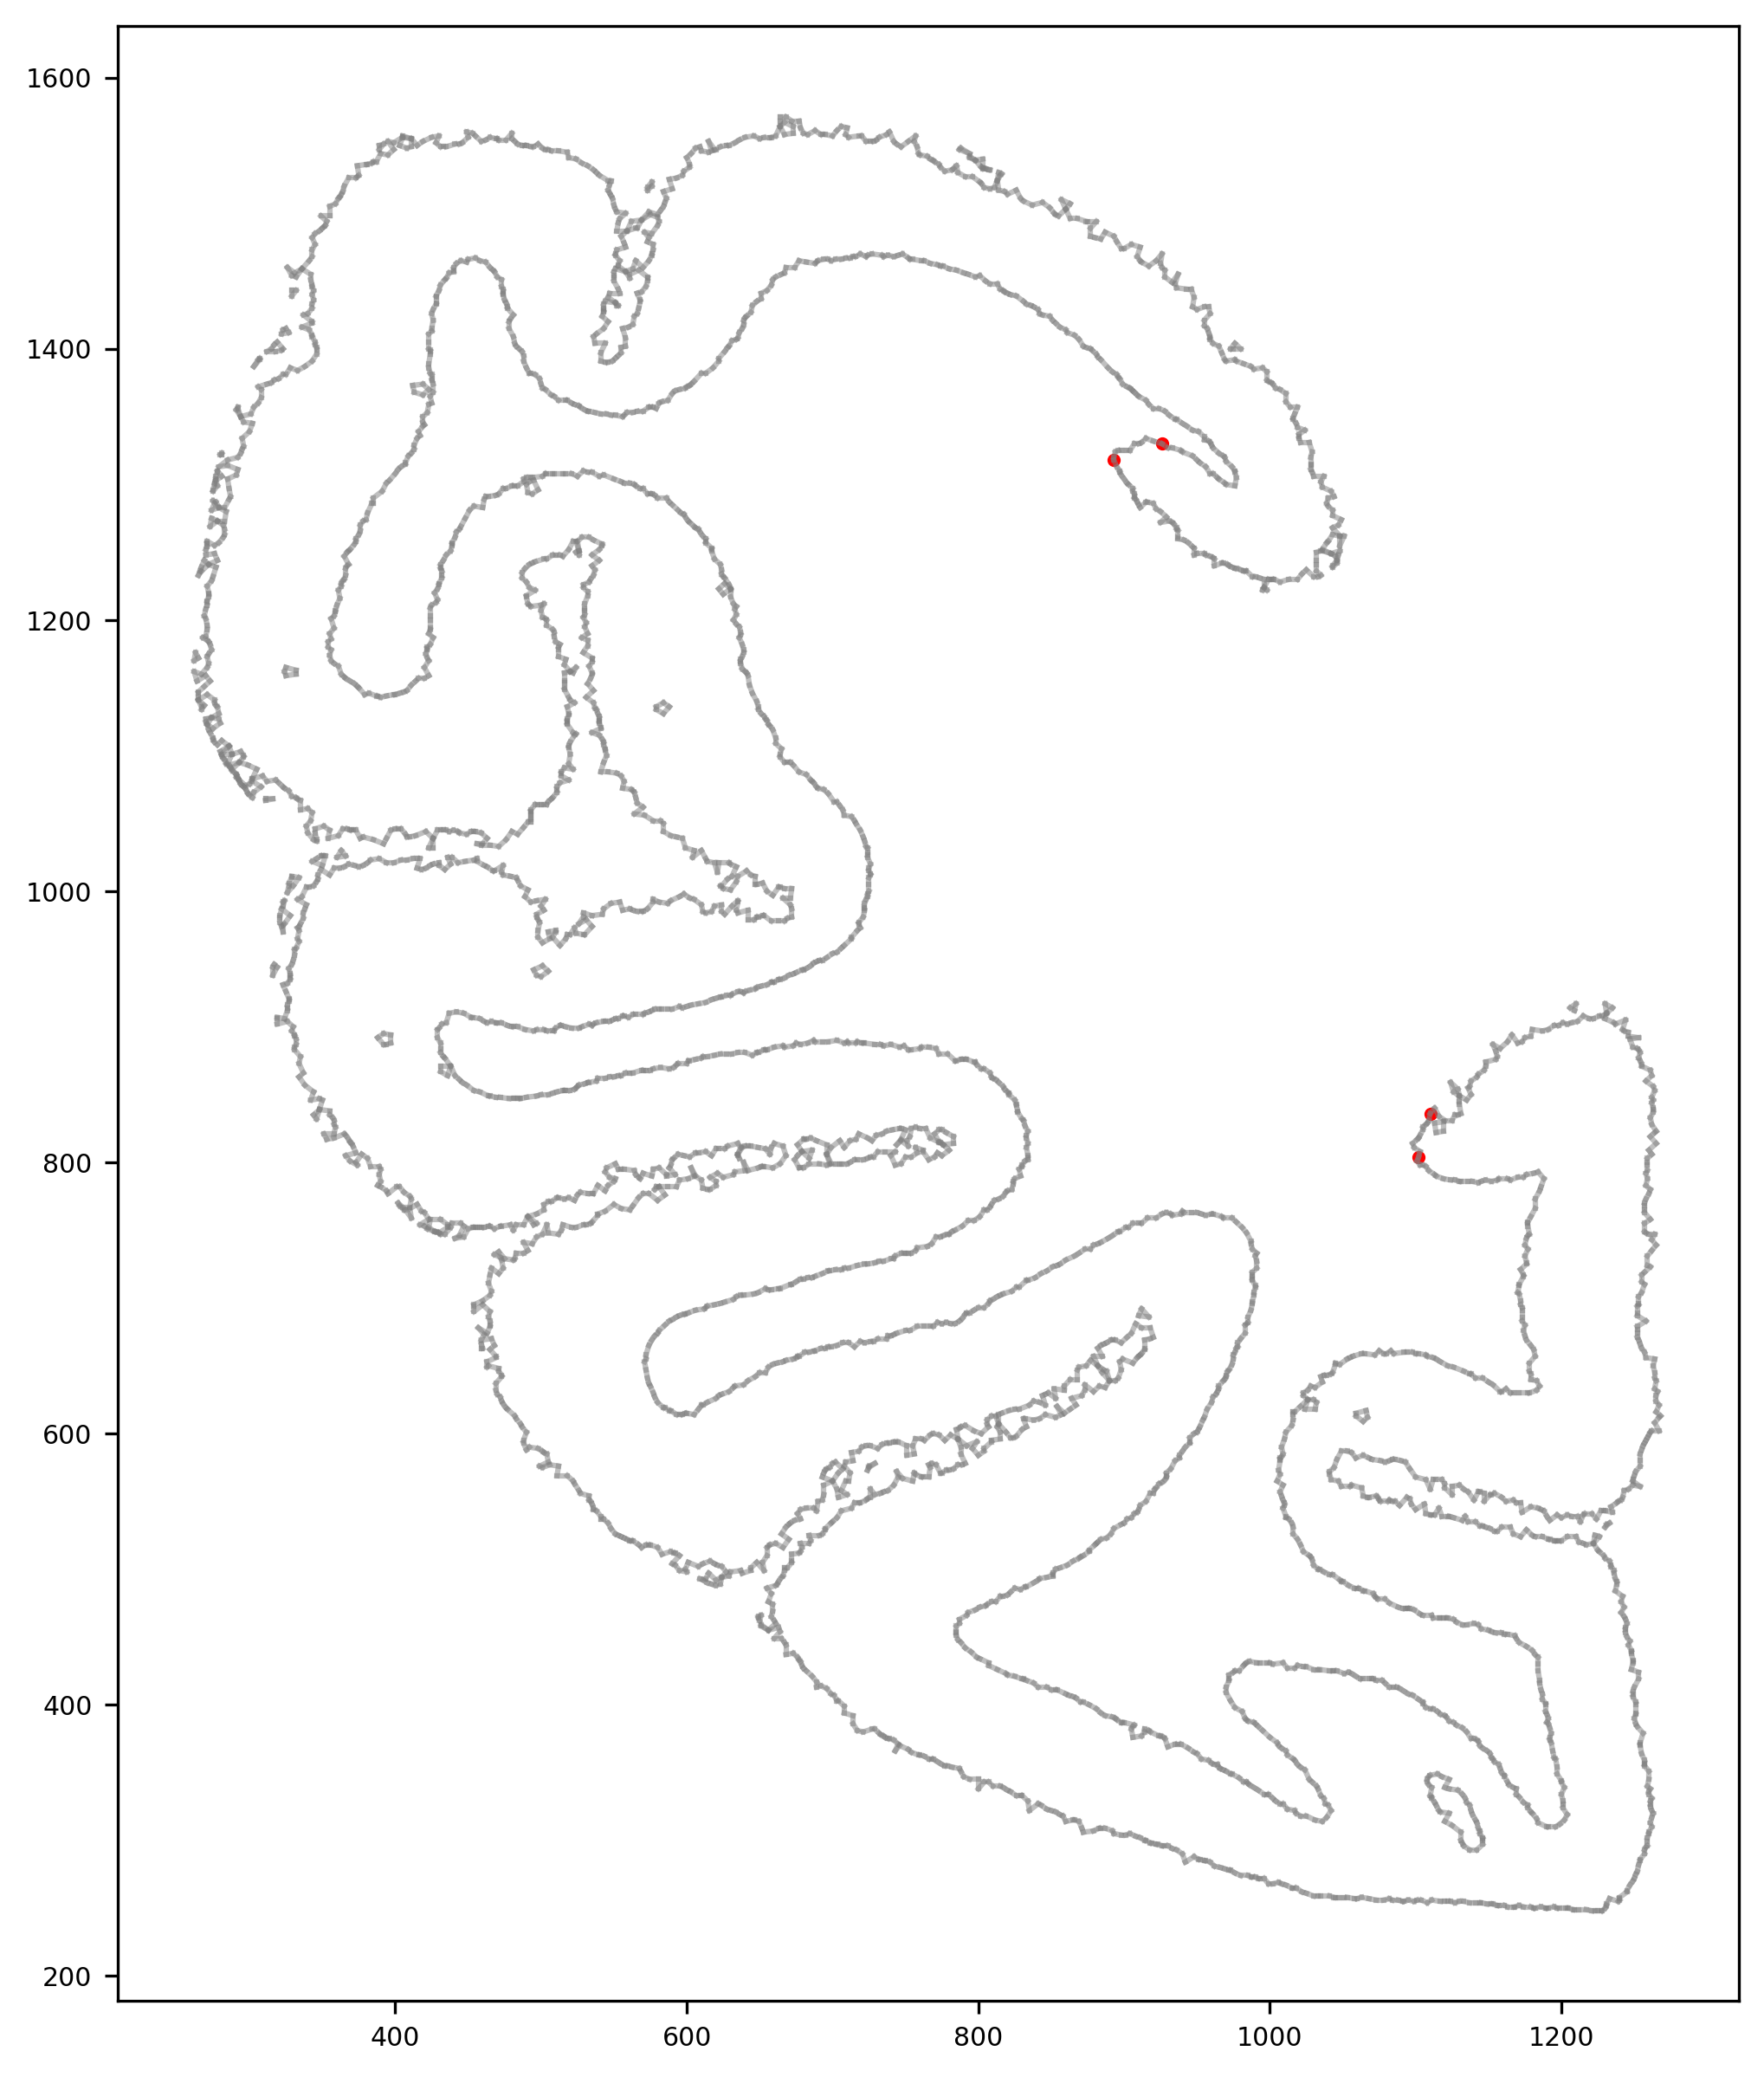

In [41]:
fig, ax = plt.subplots(figsize=(8,10))
for i, j in edges:
    plt.plot(coords[[i, j], 0], coords[[i, j], 1], color='grey', ls='-',alpha=0.5)

plt.scatter(coords[:,0],coords[:,1],s=2,color='white')

x, y = edge_pts[315]
plt.scatter(x, y, s=10, color='red')

x, y = edge_pts[1945]
plt.scatter(x, y, s=10, color='red')

x, y = edge_pts[1957]
plt.scatter(x, y, s=10, color='red')

x, y = edge_pts[303]
plt.scatter(x, y, s=10, color='red')

In [42]:
boundary_array = []
boundary_array.append(np.array([[i[0], i[1]] for i in edge_pts[315:1945+1]]))

bound_2 = edge_pts[1957:3753]
bound_2 = bound_2+edge_pts[0:303]
boundary_array.append(np.array([[i[0], i[1]] for i in bound_2]))

subset.obs['belayer'] = harmonic_slideseq(coords, boundary_array, grid_spacing=10, radius=10)

starting harmonic interpolation...


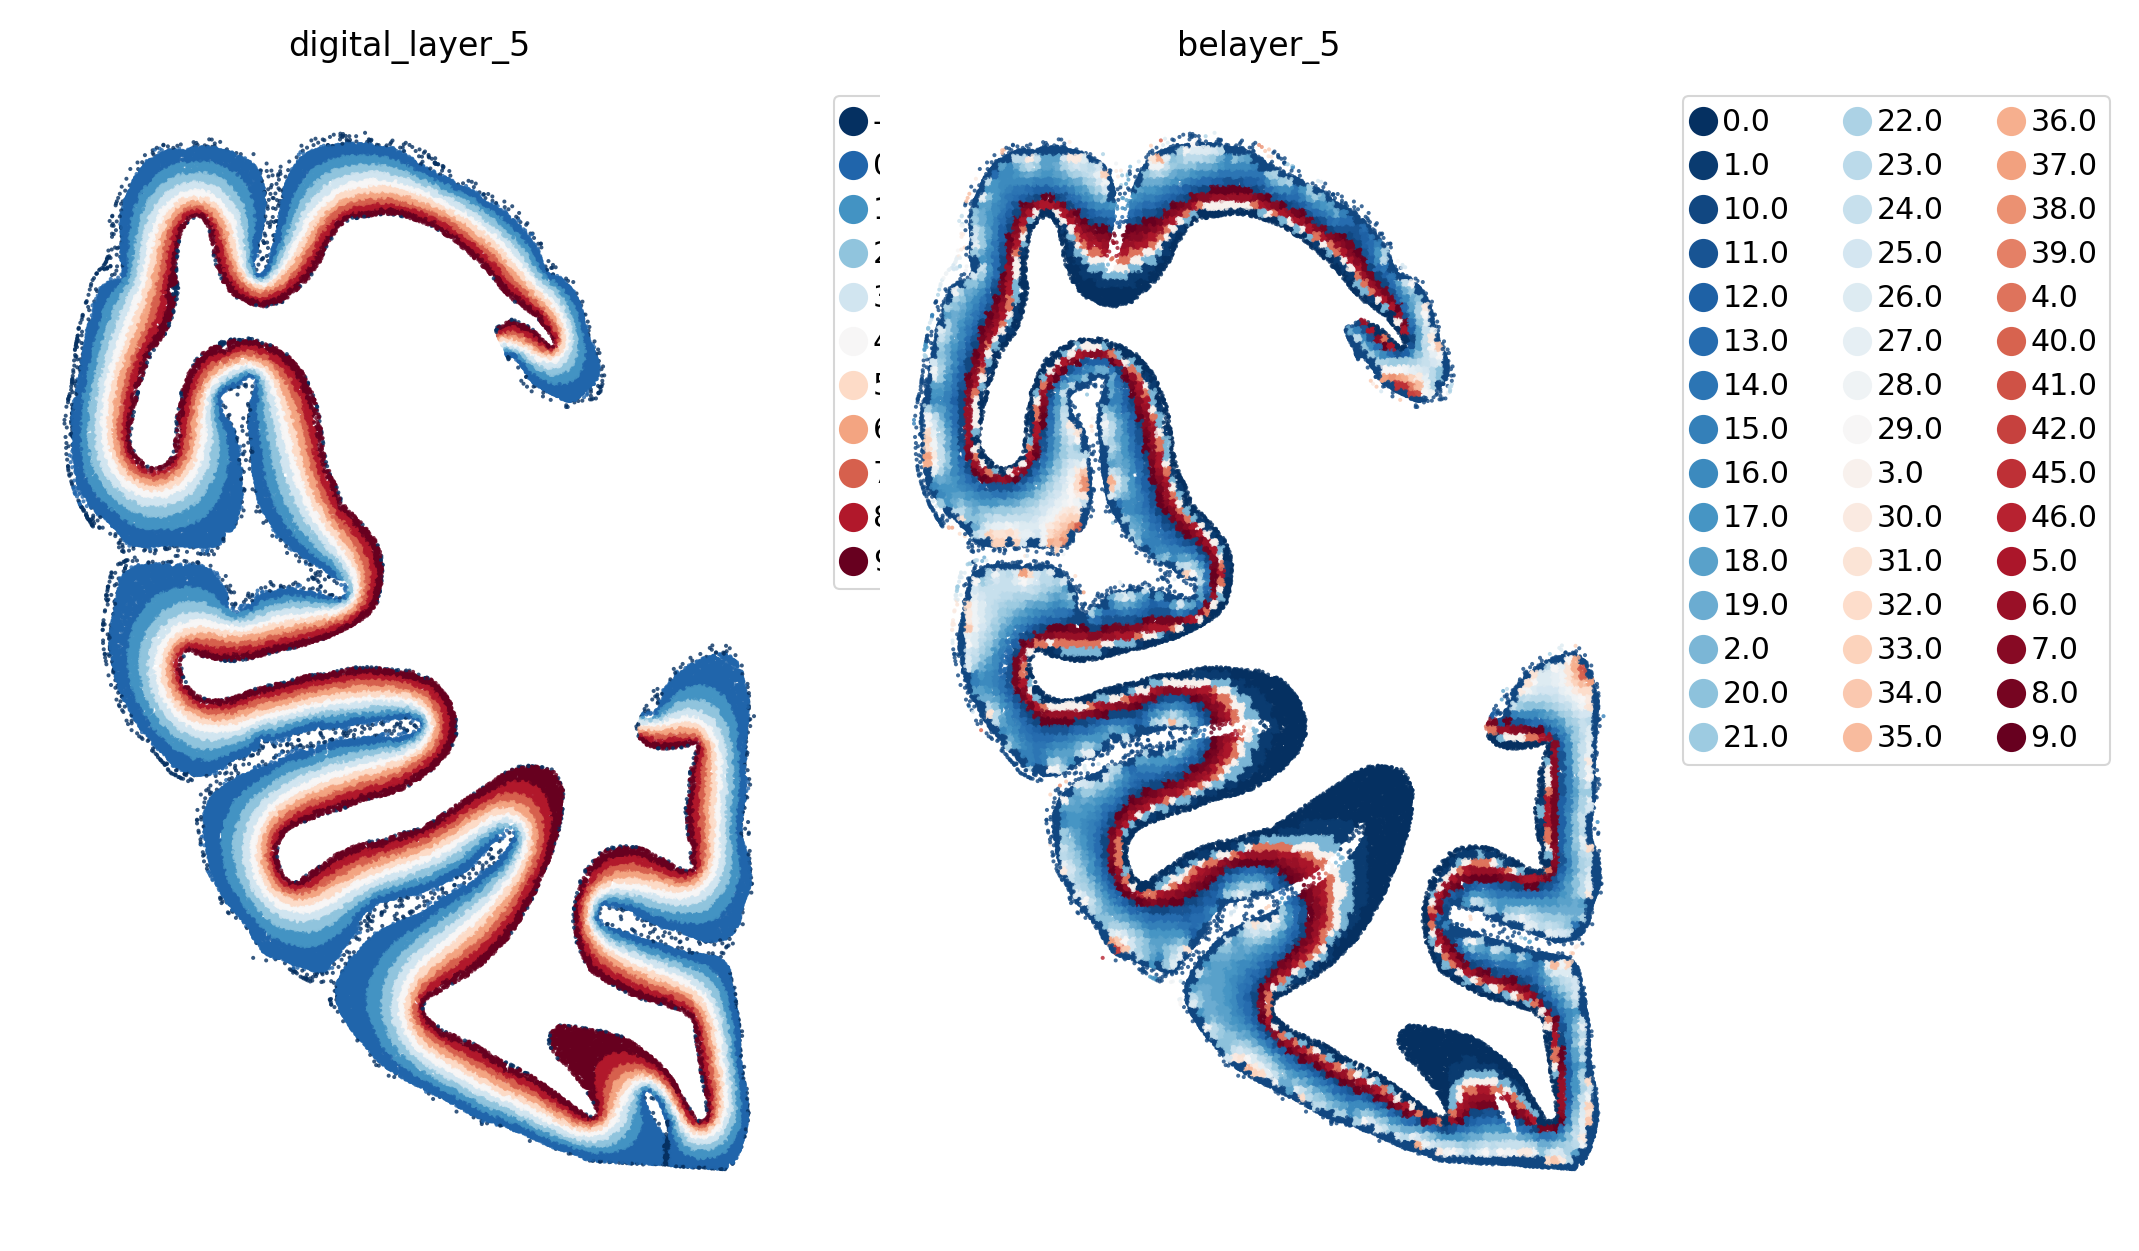

In [43]:
subset.obs['digital_layer_5'] = (subset.obs['digital_layer']-1)//10
subset.obs['belayer_5'] = (subset.obs['belayer'])//10 
subset.obs['digital_layer_5'] = subset.obs['digital_layer_5'].astype(str)
subset.obs['belayer_5'] = subset.obs['belayer_5'].astype(str)
st.pl.space(
    subset,
    color=['digital_layer_5', 'belayer_5'],
    ncols=2,
    pointsize=0.1,
    show_legend="upper left",
    figsize=(4, 5),
    color_key_cmap = "RdBu_r",
)

# CCI

In [ ]:
np.random.seed(888)

In [ ]:
%config InlineBackend.print_figure_kwargs={'dpi': 300.0}

## Resources used for the CosMx sample can be found: https://www.dropbox.com/scl/fo/z3bvppoq96vg442lma0rs/ACIXLqp-FXjuYQ2ZeAeHFEA?rlkey=84h21aoigdxrpfz9yrbsyepwg&st=55ozincu&dl=0
## Database files used here can be found: https://www.dropbox.com/scl/fo/dcd95so9zhkb8lnjkkxep/ANwmkFeb-sgtS89leHQezlU?rlkey=saiul4j5rr1vt6lwjl4hirmwh&st=brpjqw2c&dl=0

### Make sure to change each file path to the relevant local folder

In [47]:
# Set the Spateo database directory here:
database_dir = "/home/danielyumengzhu/spateo-release/spateo/tools/database"

## Load FOV 4 of the CosMx lung cancer sample

In [48]:
# Replace with wherever this file is stored locally
path_to_cosmx = "/home/danielyumengzhu/Single-cell-data/NSCLC_CosMx/Lung5_Rep1-Flat_files_and_images/fov_4.h5ad"
# Replace with wherever the L:R database is stored locally
lr_db = pd.read_csv(os.path.join(database_dir, "lr_db_human.csv"), index_col=0)

In [49]:
lung_fov4 = anndata.read_h5ad(path_to_cosmx)
lung_fov4.uns["__type"] = "UMI"

### Figure 5h- spatially-resolved cell types plot

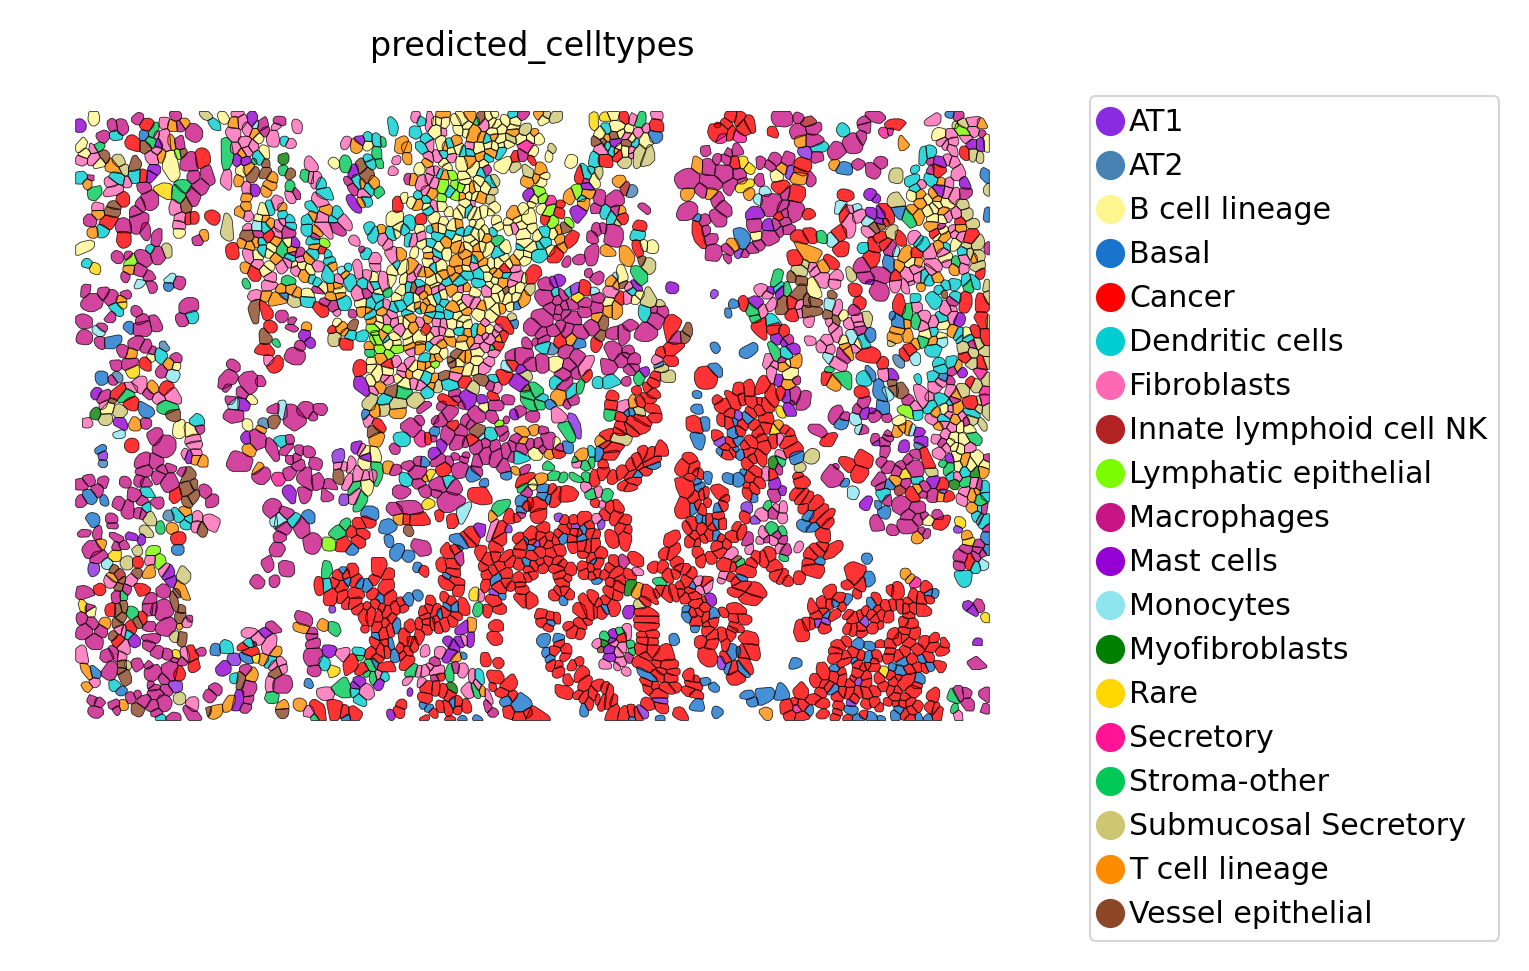

In [50]:
st.pl.geo(
    lung_fov4, 
    color=["predicted_celltypes"], 
    show_legend='upper left', 
    save_show_or_return='show', 
    figsize=(5, 3), 
    color_key=lung_fov4.uns["celltype_colors"]
)

### CCI effects prediction in the lung sample

In [ ]:
lb = 120.0
ub = 336.1

#### Run Spateo CCI model (can skip if predictions .csv file was created locally or downloaded from the folder)

In [ ]:
# Set to the folders that the inputs (ligands list, receptors list, targets list) are contained in and that the outputs (model results) will save to:
cci_input_directory = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/CCI_inputs"
cci_output_directory = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/CCI_outputs"
cci_output_id = os.path.join(cci_output_directory, "lung_fov4.csv")
cci_ligands_file = os.path.join(cci_input_directory, "fov4_ligands.txt")
cci_receptors_file = os.path.join(cci_input_directory, "fov4_receptors.txt")
cci_targets_file = os.path.join(cci_input_directory, "fov4_targets.txt")

In [ ]:
# For clarity, this is how the distance bounds are determined
lb = st.tl.find_neighbors.find_bw_for_n_neighbors(
    lung_fov4,
    coords_key="spatial",
    target_n_neighbors=9,
    initial_bw=100,
    exclude_self=True
)

In [ ]:
ub = st.tl.find_neighbors.find_bw_for_n_neighbors(
    lung_fov4,
    coords_key="spatial",
    target_n_neighbors=70,
    initial_bw=100,
    exclude_self=True
)

In [ ]:
# Define inputs:
adata_path = path_to_cosmx
output_path = cci_output_directory
# Use the ligand/receptor paths from the model fitting:
ligand_path = cci_ligands_file
receptor_path = cci_receptors_file
target_path = cci_targets_file
cci_dir_path = database_dir
mod_type = "lr"
species = "human"
distr = "poisson"

# Key storing cell type information
group_key = "predicted_celltypes"

# Key storing your spatial coordinates
coords_key = "spatial"
distance_membrane_bound = lb
distance_secreted = ub
minbw = lb * 1.5
maxbw = ub

if not os.path.exists(os.path.dirname(output_path)):
    os.makedirs(os.path.dirname(output_path))

In [ ]:
parser, args_list = st.tl.define_spateo_argparse(
    adata_path=adata_path,
    custom_lig_path=ligand_path,
    custom_rec_path=receptor_path,
    targets_path=target_path,
    cci_dir=cci_dir_path,
    mod_type=mod_type,
    distr=distr,
    species=species,
    group_key=group_key,
    coords_key=coords_key,
    distance_membrane_bound=distance_membrane_bound,
    distance_secreted=distance_secreted,
    minbw=minbw,
    maxbw=maxbw,
    output_path=output_path,
)

In [ ]:
import time

t1 = time.time()

swr_model = st.tl.MuSIC(parser, args_list)
swr_model._set_up_model()
swr_model.fit()
swr_model.predict_and_save()

t_last = time.time()

print("Total Time Elapsed:", np.round(t_last - t1, 2), "seconds")
print("-" * 60)

In [ ]:
# Note that the predictions.csv file is also provided in the Dropbox

#### Run COMMOT for the comparison (can skip if the AnnData object was already created locally or downloaded from the folder)

In [ ]:
np.random.seed(42)

In [ ]:
# Processing for secreted signaling (will add fields to the AnnData object)
df_cellchat = ct.pp.ligand_receptor_database(species='human', signaling_type='Secreted Signaling', database='CellChat')
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, lung_fov4, min_cell_pct=0.05)

ct.tl.spatial_communication(
    lung_fov4,
    database_name='cellchat', 
    df_ligrec=df_cellchat_filtered, 
    dis_thr=ub, 
    heteromeric=True, 
    pathway_sum=True
)

In [ ]:
# Processing for ECM signaling
df_cellchat = ct.pp.ligand_receptor_database(species='human', signaling_type='ECM-Receptor', database='CellChat')
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, lung_fov4, min_cell_pct=0.05)

# Both models operate w/ the assumption that ECM components diffuse about as far as other extracellular factors
ct.tl.spatial_communication(
    lung_fov4,
    database_name='cellchat', 
    df_ligrec=df_cellchat_filtered, 
    dis_thr=ub, 
    heteromeric=True, 
    pathway_sum=True
)

In [ ]:
# Processing for membrane-bound signaling
df_cellchat = ct.pp.ligand_receptor_database(species='human', signaling_type='Cell-Cell Contact', database='CellChat')
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, lung_fov4, min_cell_pct=0.05)

ct.tl.spatial_communication(
    lung_fov4,
    database_name='cellchat', 
    df_ligrec=df_cellchat_filtered, 
    dis_thr=lb, 
    heteromeric=True, 
    pathway_sum=True
)

In [ ]:
# Save AnnData object with COMMOT info- this will also be uploaded to the Dropbox
path_to_cosmx_commot = "/mnt/d/SCData/Spateo_data/CosMx/fov_4_COMMOT.h5ad"
lung_fov4.write_h5ad(path_to_cosmx_commot)

In [ ]:
# Compute signal received for each cell predicted by COMMOT:
commot_signal_received = pd.DataFrame(0, columns=lung_fov4.obsp.keys(), index=lung_fov4.obs_names)
for key in lung_fov4.obsp.keys():
    sig_array = lung_fov4.obsp[key]
    test = np.array(sig_array.sum(axis=0)).reshape(-1)
    commot_signal_received.loc[:, key] = test

In [ ]:
save_path = "/mnt/d/SCData/Spateo_data/CosMx/fov_4_COMMOT_signal_received.csv"
commot_signal_received.to_csv(save_path)

### Figure 5l- comparison of COMMOT signal to Spateo signal

In [51]:
path_to_commot_signal_received = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/COMMOT_benchmark_materials/fov4_commot_signal_received.csv"
commot_signal_received = pd.read_csv(path_to_commot_signal_received, index_col=0)
lung_fov4_spateo = anndata.read_h5ad(path_to_cosmx)

In [52]:
# Path to Spateo model design matrix
spateo_dm_path = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/COMMOT_benchmark_materials/Spateo_design_matrix_full.csv"
spateo_dm = pd.read_csv(spateo_dm_path, index_col=0)

In [53]:
# We define the presence or absence of a received signal in each cell using the Jaccard index, applied to both the Spateo signal array and the COMMOT signal array
def jaccard(x, y):
    """Compute the Jaccard index between two binary vectors."""
    from scipy.spatial.distance import cdist
    
    # Ensure the input vectors are boolean
    x = x.astype(bool)
    y = y.astype(bool)
    
    # Compute the Jaccard distance using cdist function
    jaccard_distance = cdist(x.values.reshape(1, -1), y.values.reshape(1, -1), metric='jaccard')
    
    # Convert Jaccard distance to Jaccard index
    jaccard_index = 1 - jaccard_distance[0][0]
    
    return jaccard_index

In [54]:
# This is to match the interactions between the Spateo array and the COMMOT array
def match_columns(commot_columns, design_columns):
    matched_columns = {}
    for col in commot_columns:
        # Only consider columns with three dashes
        if col.count("-") != 3:
            continue

        # Extracting the left and right parts of the commot column
        _, _, prefix, suffix = col.split("-")
        expected_col_name = f"{prefix}:{suffix}"
        
        # Checking if the expected column name exists in the design columns
        if expected_col_name in design_columns:
            matched_columns[col] = expected_col_name
    return matched_columns

def compute_jaccard(matched_columns, commot_df, design_df):
    output = []
    for commot_col, design_col in matched_columns.items():
        commot_data = commot_df[commot_col]
        design_data = design_df[design_col]
        
        # Computing the Jaccard index
        jaccard_index = jaccard(commot_data > 0, design_data > 0)
        output.append((commot_col, design_col, jaccard_index))
    
    return output

In [55]:
matched_columns = match_columns(
    commot_signal_received.columns,
    spateo_dm.columns
)

In [56]:
jaccard_indices = compute_jaccard(
    matched_columns,
    commot_signal_received,
    spateo_dm
)

In [57]:
jaccard_df = pd.DataFrame(
    jaccard_indices,
    columns=['Commot Column', 'Design Column', 'Jaccard Index']
)
jaccard_df

Commot Column        Design Column  Jaccard Index
0    commot-cellchat-ANGPTL1-ITGA1_ITGB1  ANGPTL1:ITGA1_ITGB1       0.799574
1              commot-cellchat-AREG-EGFR            AREG:EGFR       0.828571
2        commot-cellchat-AREG-EGFR_ERBB2      AREG:EGFR_ERBB2       0.879699
3     commot-cellchat-BMP2-BMPR1A_ACVR2A   BMP2:BMPR1A_ACVR2A       0.791667
4      commot-cellchat-BMP2-BMPR1A_BMPR2    BMP2:BMPR1A_BMPR2       0.841463
..                                   ...                  ...            ...
264           commot-cellchat-WNT5B-FZD4           WNT5B:FZD4       0.901685
265           commot-cellchat-WNT5B-FZD5           WNT5B:FZD5       0.938959
266           commot-cellchat-WNT5B-FZD6           WNT5B:FZD6       0.938650
267           commot-cellchat-WNT5B-FZD7           WNT5B:FZD7       0.930337
268           commot-cellchat-WNT5B-FZD8           WNT5B:FZD8       0.906250

[269 rows x 3 columns]

In [58]:
# Number of "active signals" for each cell:
commot_features = jaccard_df["Commot Column"]
spateo_features = jaccard_df["Design Column"]

commot_sub = commot_signal_received[commot_features]
spateo_dm_sub = spateo_dm[spateo_features]

In [59]:
# Number of "active signals" for each cell:
commot_sub_nz = commot_sub.applymap(lambda x: 1 if x != 0 else 0)
spateo_dm_sub_nz = spateo_dm_sub.applymap(lambda x: 1 if x != 0 else 0)

active_signals_commot = commot_sub_nz.sum(axis=1)
active_signals_spateo = spateo_dm_sub_nz.sum(axis=1)

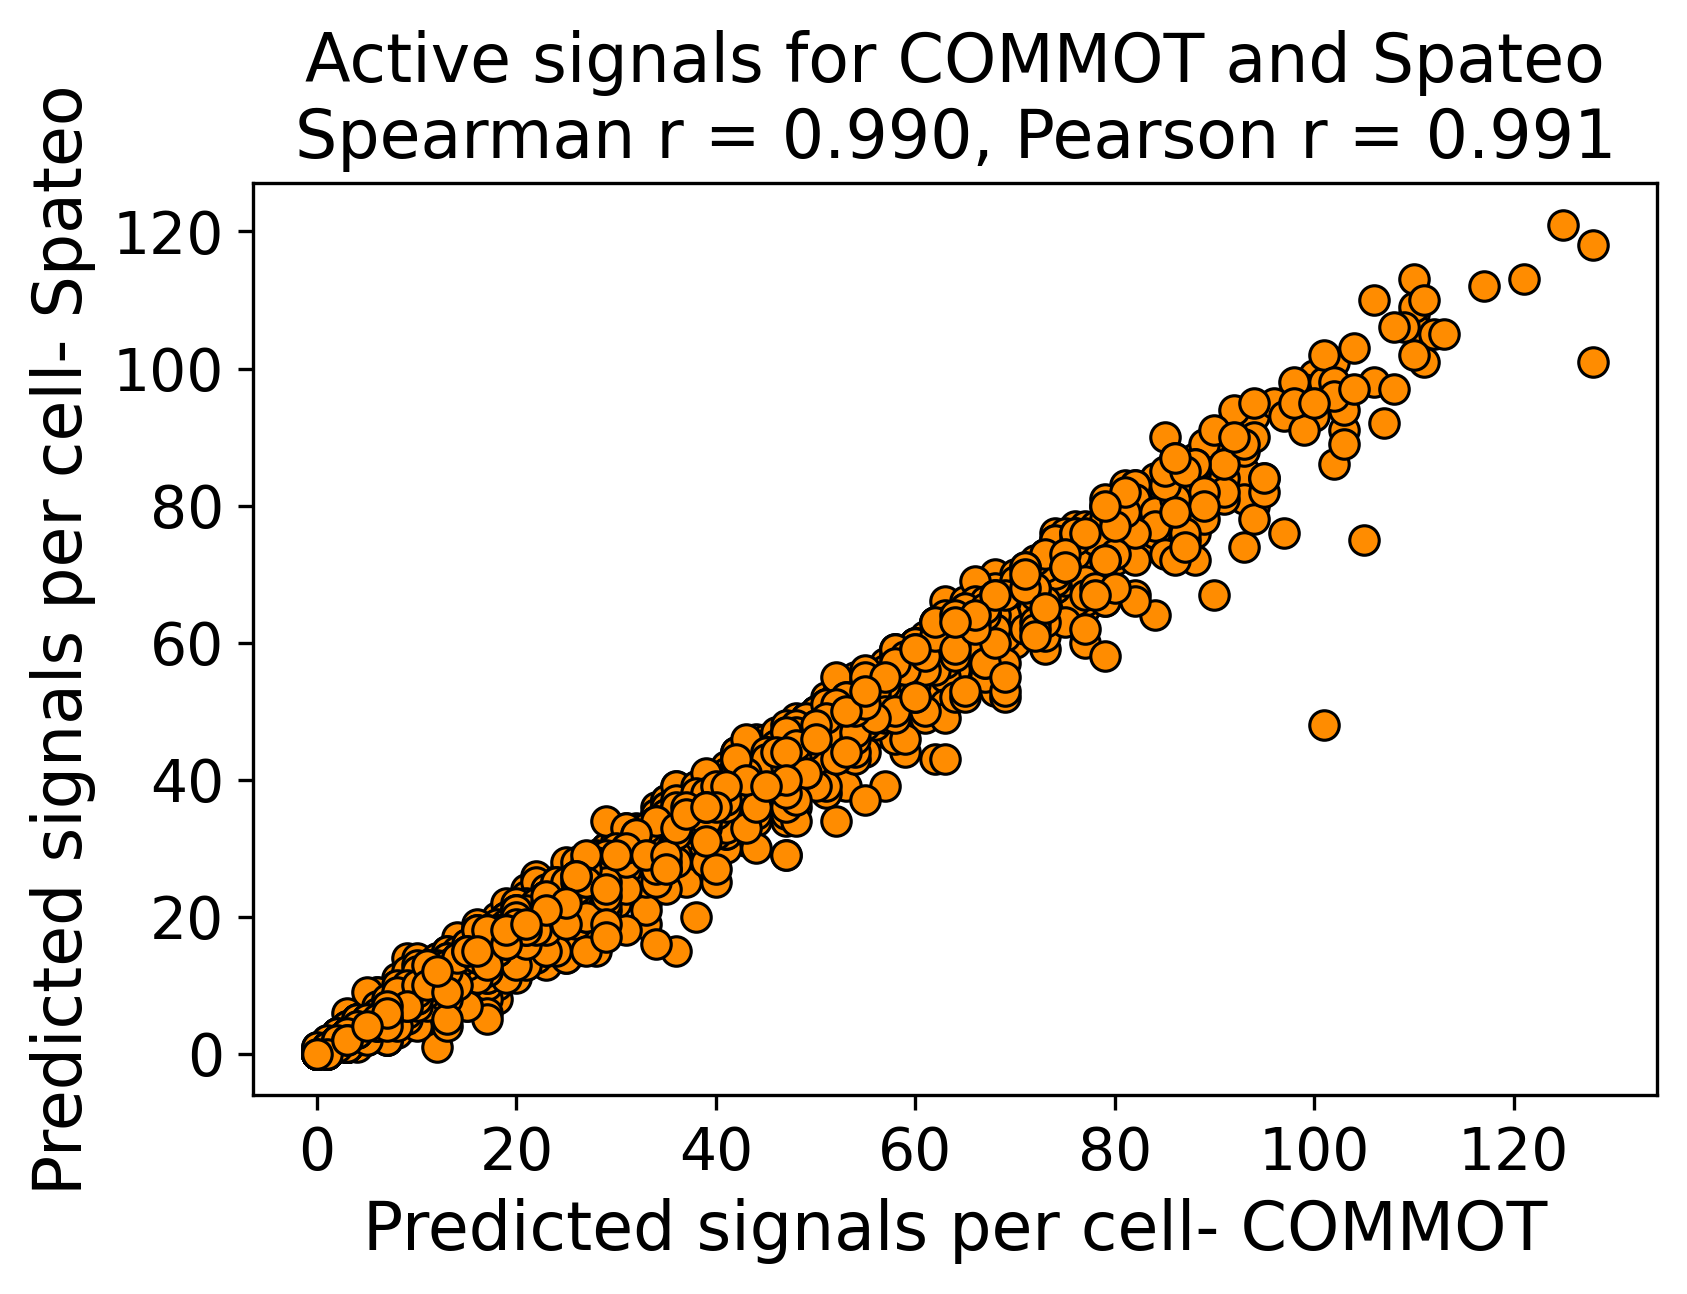

In [60]:
from scipy.stats import pearsonr, spearmanr
rp_nonzero, _ = pearsonr(active_signals_commot, active_signals_spateo)
r_nonzero, _ = spearmanr(active_signals_commot, active_signals_spateo)

# Plot the scatter plot for nonzero y values
plt.scatter(active_signals_commot, active_signals_spateo, s=50, facecolors='darkorange', edgecolors='black', linewidths=0.75)

# Set the title and axis labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f"Active signals for COMMOT and Spateo\nSpearman r = {r_nonzero:.3f}, Pearson r = {rp_nonzero:.3f}", fontsize=16)
plt.xlabel("Predicted signals per cell- COMMOT", fontsize=16)
plt.ylabel("Predicted signals per cell- Spateo", fontsize=16)

# Show the plot
plt.show()

In [61]:
# Find the local path where target genes were expressed
cci_input_directory = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/CCI_inputs"
cci_targets_file = os.path.join(cci_input_directory, "fov4_targets.txt")

In [62]:
with open(cci_targets_file, "r") as file:
    lines = file.readlines()

targets = [line.strip() for line in lines]
targets

['KRT19',
 'OLFM4',
 'S100A6',
 'CEACAM6',
 'TM4SF1',
 'KRT17',
 'MMP1',
 'ITGB4',
 'IER3',
 'KRT8',
 'ANXA2',
 'DDR1',
 'EPHA2',
 'EPCAM',
 'S100P',
 'SOX9',
 'ITGA3',
 'CDH1',
 'VEGFA',
 'GSTP1',
 'LTF',
 'AGR2',
 'CCL20',
 'LTB',
 'TYK2',
 'SERPINA3',
 'SPINK1']

#### Use COMMOT signal to predict gene expression (skip to the next section if the Spearman correlations file was already saved)

In [ ]:
lung_fov4_spateo = anndata.read_h5ad(path_to_cosmx)

In [ ]:
path_to_commot_signal_received = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/COMMOT_benchmark_materials/fov4_commot_signal_received.csv"
commot_signal_received = pd.read_csv(path_to_commot_signal_received, index_col=0)

In [ ]:
adata_targets = lung_fov4_spateo[:, targets].copy()

In [ ]:
targets_df = pd.DataFrame(adata_targets.X.toarray(), columns=targets, index=adata_targets.obs_names)
targets_df

In [ ]:
# Iteratively perform Poisson regression on each column of AnnData object
models = {}
pearson_correlations_COMMOT = {}
spearman_correlations_COMMOT = {}
pearson_correlations_nz_subset_COMMOT = {}
spearman_correlations_nz_subset_COMMOT = {}
predictions = pd.DataFrame(0, columns=targets, index=adata_targets.obs_names)
not_modeled = []

for col in targets_df.columns:
    print(f"Performing Poisson regression on {col}")
    y = targets_df[col].values
    nonzero_names = targets_df[col][targets_df[col] != 0].index.tolist()
    y_nz = targets_df.loc[nonzero_names, col].values

    X = commot_signal_received
    try:
        model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
        models[col] = model
        y_pred = model.predict(X).values
        predictions[col] = y_pred
        y_pred_nz = predictions.loc[nonzero_names, col].values

        rp, _ = stats.pearsonr(y, y_pred)
        rs, _ = stats.spearmanr(y, y_pred)
        pearson_correlations_COMMOT[col] = rp
        spearman_correlations_COMMOT[col] = rs
    
        print(f"Pearson correlation coefficient for {col}: {rp}")
        print(f"Spearman correlation coefficient for {col}: {rs}")

        rp, _ = stats.pearsonr(y_nz, y_pred_nz)
        rs, _ = stats.spearmanr(y_nz, y_pred_nz)
        pearson_correlations_nz_subset_COMMOT[col] = rp
        spearman_correlations_nz_subset_COMMOT[col] = rs

        print(f"Pearson correlation coefficient for nonzero {col}: {rp}")
        print(f"Spearman correlation coefficient for nonzero {col}: {rs}")
    except:
        not_modeled.append(col)

In [ ]:
# Save results- for the figure panel, only the Spearman correlation is shown, so save this file
save_dir = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/COMMOT_benchmark_materials"
pd.DataFrame.from_dict(spearman_correlations_COMMOT, orient='index', columns=['spearman']).to_csv(os.path.join(save_dir, "spearman_correlations.csv"))
# Save list of not-modeled genes:
with open(os.path.join(save_dir, "COMMOT_not_modeled.txt"), "w") as file:
    for g in not_modeled:
        file.write(f"{g}\n")

In [ ]:
# Also save the models
model_dir = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/COMMOT_benchmark_materials/COMMOT_models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for model_name, model in models.items():
    with open(os.path.join(model_dir, f"{model_name}.pkl"), "wb") as file:
        pickle.dump(model, file)

### Figure S5j- Spearman comparison

In [63]:
lung_fov4_spateo = anndata.read_h5ad(path_to_cosmx)
adata_targets = lung_fov4_spateo[:, targets].copy()

In [64]:
targets_df = pd.DataFrame(adata_targets.X.toarray(), columns=targets, index=adata_targets.obs_names)
targets_df

KRT19  OLFM4  S100A6  CEACAM6  TM4SF1  KRT17  MMP1  ITGB4  IER3  KRT8  \
2_4         0      0       1        0       0      0     0      0     0     0   
3_4         3      0       5        0       0      0     0      0     0     2   
9_4         0      0       0        0       0      0     0      0     0     0   
10_4        0      0       0        0       0      0     0      0     0     0   
11_4        0      0       1        0       0      0     0      0     0     1   
...       ...    ...     ...      ...     ...    ...   ...    ...   ...   ...   
3612_4      5     11       8        0       1      1     1      3     4     2   
3613_4      3      1       2        1       0      0     0      0     0     1   
3614_4      8      3      20        5       2      6     1      0     2     6   
3616_4     10      8       2        1       4      2     2      0     2     4   
3617_4      4     13       1        4       3      4     0      0     2     3   

        ...  CDH1  VEGFA  GSTP1  LTF  AGR2  CCL20  LTB  TYK2  SERPINA3  SPINK1  
2_4     ...     0      0      0    0     0      0    0     1         0       0  
3_4     ...     0      0      3    4     1      0    0     3         0       0  
9_4     ...     0      0      0    0     0      0    0    10         0       0  
10_4    ...     0      0      0    0     0      0    0     6         0       0  
11_4    ...     0      0      2    0     0      0    0     0         0       0  
...     ...   ...    ...    ...  ...   ...    ...  ...   ...       ...     ...  
3612_4  ...     0      0      5    0     0      0    0     0         1       0  
3613_4  ...     0      0      1    0     0      0    0     0         0       0  
3614_4  ...     0      1      4    0     1      0    0     3         0       0  
3616_4  ...     0      0      0    0     1      0    0     1         0       0  
3617_4  ...     1      2      4    0     0      0    0     3         0       1  

[3292 rows x 27 columns]

In [65]:
# Load Spateo predictions to compute metrics for those as well:
cci_output_directory = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/CCI_outputs"
spateo_save_path = os.path.join(cci_output_directory, "predictions.csv")
spateo_reconst_df = pd.read_csv(spateo_save_path, index_col=0)

In [66]:
save_dir = "/home/danielyumengzhu/Single-cell-analysis/Spateo_benchmark_non-embryo_figures/fig5_CosMx_materials/COMMOT_benchmark_materials"
commot_correlations_path = os.path.join(save_dir, "spearman_correlations.csv")
spearman_correlations_COMMOT = pd.read_csv(commot_correlations_path, index_col=0)

In [67]:
# Model fitting may have errored for some of these genes for the COMMOT model:
if os.path.exists(os.path.join(save_dir, "COMMOT_not_modeled.txt")):
    with open(os.path.join(save_dir, "COMMOT_not_modeled.txt")) as file:
        content = file.read()
        # Assuming each item is on a separate line
        not_modeled = content.splitlines()
else:
    not_modeled = []

not_modeled

[]

In [68]:
pearson_correlations_spateo = {}
spearman_correlations_spateo = {}
pearson_correlations_spateo_nz = {}
spearman_correlations_spateo_nz = {}

for col in spateo_reconst_df.columns:
    # Load this prediction separately:
    if col not in not_modeled:
        y = targets_df[col].values.reshape(-1)
        y_pred = spateo_reconst_df[col].values.reshape(-1)

        nonzero_names = targets_df[col][targets_df[col] != 0].index.tolist()
        y_nz = targets_df.loc[nonzero_names, col].values
        y_pred_nz = spateo_reconst_df.loc[nonzero_names, col].values

        rp, _ = stats.pearsonr(y, y_pred)
        rs, _ = stats.spearmanr(y, y_pred)
        pearson_correlations_spateo[col] = rp
        spearman_correlations_spateo[col] = rs
    
        print(f"Pearson correlation coefficient for {col}: {rp}")
        print(f"Spearman correlation coefficient for {col}: {rs}")

        rp, _ = stats.pearsonr(y_nz, y_pred_nz)
        rs, _ = stats.spearmanr(y_nz, y_pred_nz)
        pearson_correlations_spateo_nz[col] = rp
        spearman_correlations_spateo_nz[col] = rs
    
        print(f"Pearson correlation coefficient for {col}, nonzero subset: {rp}")
        print(f"Spearman correlation coefficient for {col}, nonzero subset: {rs}")

Pearson correlation coefficient for OLFM4: 0.9876696895351209
Spearman correlation coefficient for OLFM4: 0.8372033382229889
Pearson correlation coefficient for OLFM4, nonzero subset: 0.9822085785642265
Spearman correlation coefficient for OLFM4, nonzero subset: 0.9795683477676382
Pearson correlation coefficient for AGR2: 0.836317733643932
Spearman correlation coefficient for AGR2: 0.6868540743778386
Pearson correlation coefficient for AGR2, nonzero subset: 0.9505923350149378
Spearman correlation coefficient for AGR2, nonzero subset: 0.9097987654530427
Pearson correlation coefficient for TYK2: 0.9668692267353697
Spearman correlation coefficient for TYK2: 0.9532124409105285
Pearson correlation coefficient for TYK2, nonzero subset: 0.9643590619483663
Spearman correlation coefficient for TYK2, nonzero subset: 0.9451970821749328
Pearson correlation coefficient for S100A6: 0.9698974443299611
Spearman correlation coefficient for S100A6: 0.9426094029137065
Pearson correlation coefficient for 

In [69]:
# Comparative barplot:
# Create dataframe
spearman_df = pd.DataFrame({'Labels': list(spearman_correlations_COMMOT.index), 
                            'COMMOT-derived': spearman_correlations_COMMOT.values.reshape(-1), 
                            'Spateo': list(spearman_correlations_spateo.values())}).melt('Labels', var_name='Model', value_name='Correlation')

In [70]:
pastel_colors = sns.color_palette("pastel")

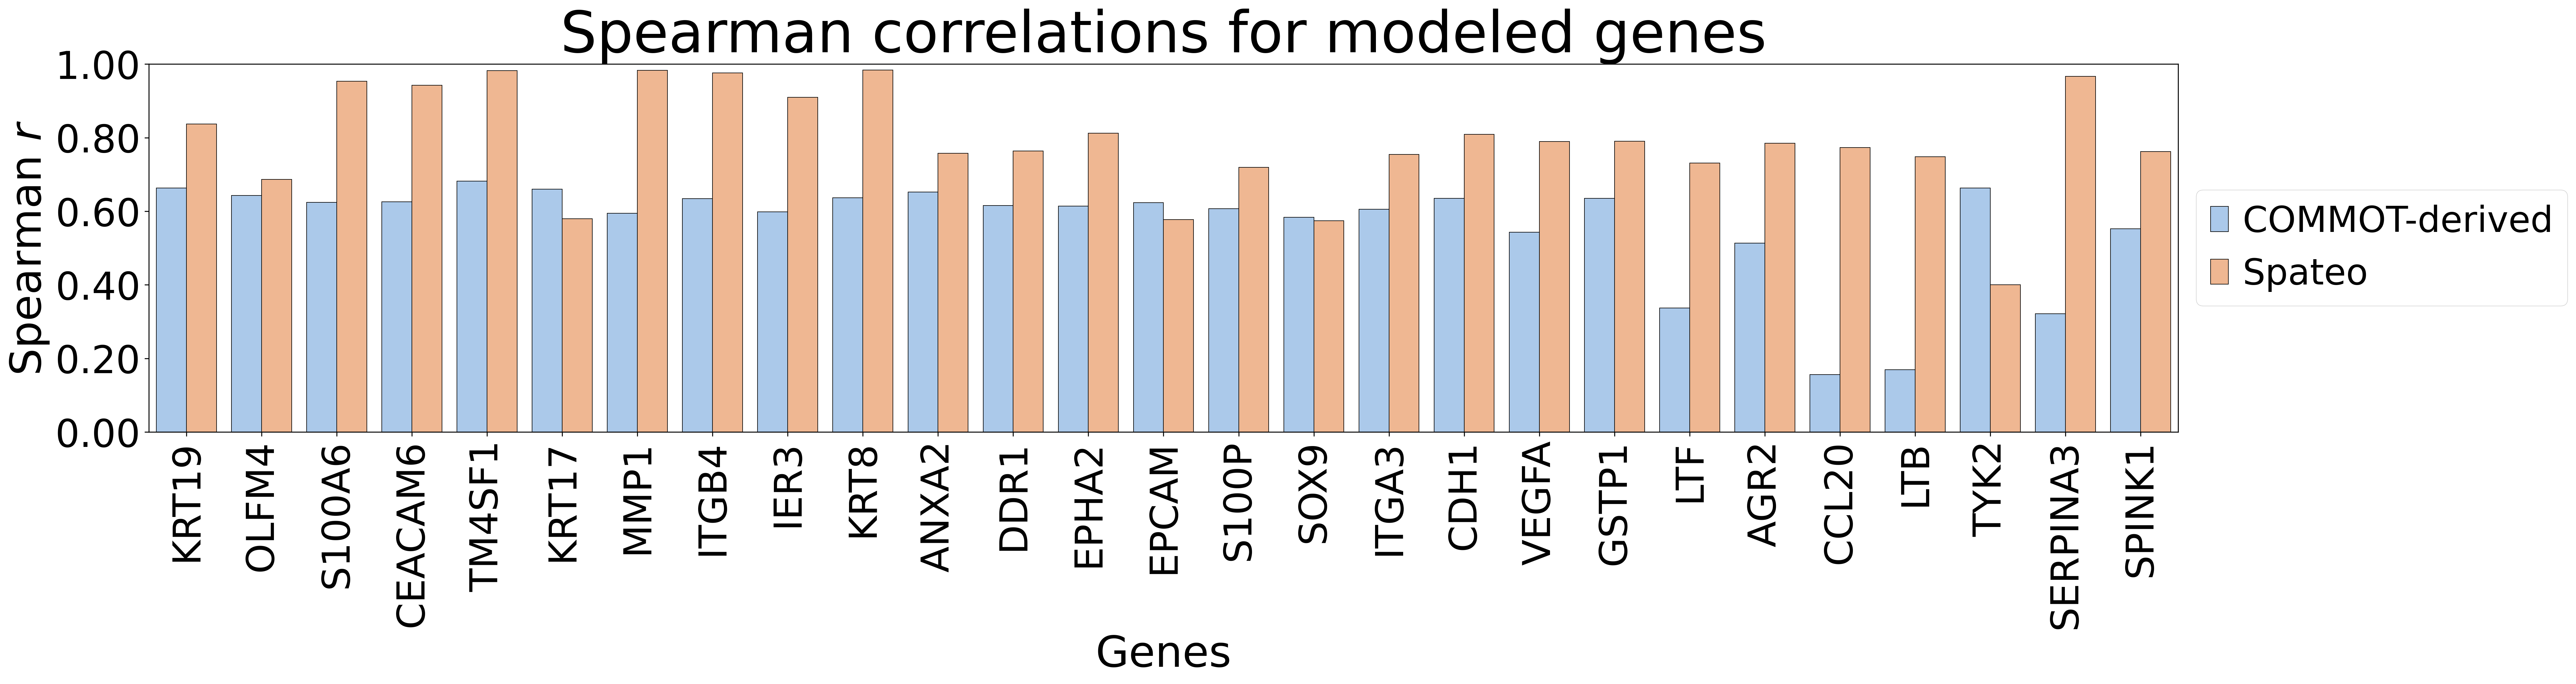

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(30, 8))
sns.barplot(x='Labels', y='Correlation', hue='Model', data=spearman_df, palette=pastel_colors, edgecolor='black')
ax.set_title('Spearman correlations for modeled genes', fontsize=48)
ax.set_xlabel('Genes', fontsize=36)
ax.set_ylabel(r'Spearman ${r}$', fontsize=36)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=32)  # Rotate x-axis labels
ax.set_ylim(0, 1)
# Get current y-tick labels and convert them to string with desired format
y_tick_labels = [f'{label:.2f}' for label in ax.get_yticks()]
# Set new y-tick labels
ax.set_yticklabels(y_tick_labels, fontsize=32)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=30)

plt.tight_layout()
plt.show()